In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 股票预测类
class StockPredictor:
    def __init__(self, data_file='daily_price.csv'):
        """
        初始化股票预测器
        
        参数:
        data_file: 数据文件路径
        """
        self.data_file = data_file
        self.df = None
        self.stock_codes = None
        self.mm_scaler = MinMaxScaler(feature_range=(0, 1))
        self.time_steps = 10
        
    def load_data(self):
        """加载股票数据"""
        print("正在加载数据...")
        self.df = pd.read_csv(self.data_file)
        self.df['trade_date'] = pd.to_datetime(self.df['trade_date'])
        self.df = self.df.sort_values(['ts_code', 'trade_date'])
        self.stock_codes = self.df['ts_code'].unique()
        print(f"数据加载完成，共包含 {len(self.stock_codes)} 只股票")
        
    def list_available_stocks(self, n=10):
        """显示可用的股票代码"""
        if self.stock_codes is None:
            self.load_data()
        
        print(f"可用股票代码 (显示前{n}个):")
        for i, code in enumerate(self.stock_codes[:n]):
            stock_data = self.df[self.df['ts_code'] == code]
            print(f"{i+1}. {code} - 数据从 {stock_data['trade_date'].min().date()} 到 {stock_data['trade_date'].max().date()}")
        
        if len(self.stock_codes) > n:
            print(f"... 还有 {len(self.stock_codes) - n} 只股票")
        
        return self.stock_codes
    
    def validate_stock_code(self, stock_code):
        """验证股票代码是否存在"""
        if self.stock_codes is None:
            self.load_data()
        
        if stock_code not in self.stock_codes:
            print(f"错误: 股票代码 {stock_code} 不存在")
            print("可用股票代码:")
            self.list_available_stocks(5)
            return False
        return True
    
    def create_features(self, stock_df):
        """创建技术指标特征"""
        stock_df = stock_df.copy()
        
        # 移动平均线
        stock_df['MA5'] = stock_df['close'].rolling(window=5).mean()
        stock_df['MA10'] = stock_df['close'].rolling(window=10).mean()
        stock_df['MA20'] = stock_df['close'].rolling(window=20).mean()
        
        # 价格变化率
        stock_df['price_change'] = stock_df['close'].pct_change()
        
        # RSI
        delta = stock_df['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss
        stock_df['RSI'] = 100 - (100 / (1 + rs))
        
        # MACD
        stock_df['EMA12'] = stock_df['close'].ewm(span=12, adjust=False).mean()
        stock_df['EMA26'] = stock_df['close'].ewm(span=26, adjust=False).mean()
        stock_df['MACD'] = stock_df['EMA12'] - stock_df['EMA26']
        stock_df['Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
        stock_df['MACD_Hist'] = stock_df['MACD'] - stock_df['Signal']
        
        # 布林带
        stock_df['20MA'] = stock_df['close'].rolling(window=20).mean()
        stock_df['20STD'] = stock_df['close'].rolling(window=20).std()
        stock_df['Upper'] = stock_df['20MA'] + (stock_df['20STD'] * 2)
        stock_df['Lower'] = stock_df['20MA'] - (stock_df['20STD'] * 2)
        
        # 成交量变化
        stock_df['vol_change'] = stock_df['vol'].pct_change()
        
        return stock_df
    
    def prepare_data(self, stock_code):
        """为指定股票准备数据"""
        if not self.validate_stock_code(stock_code):
            return None, None, None, None
        
        print(f"正在处理股票 {stock_code} 的数据...")
        
        # 提取股票数据
        stock_data = self.df[self.df['ts_code'] == stock_code].copy()
        
        # 检查数据量
        if len(stock_data) < 50:
            print(f"警告: 股票 {stock_code} 的数据量过少 ({len(stock_data)} 条记录)")
            return None, None, None, None
        
        # 创建特征
        stock_data = self.create_features(stock_data)
        stock_data = stock_data.dropna()
        
        # 特征列表
        features = ['open', 'high', 'low', 'close', 'vol', 'MA5', 'MA10', 'MA20', 
                   'price_change', 'RSI', 'MACD', 'Signal', 'MACD_Hist', 'vol_change']
        
        X = stock_data[features]
        y = stock_data['close'].shift(-1)
        
        # 删除NaN值
        X = X.iloc[:-1]
        y = y.iloc[:-1]
        
        print(f"数据准备完成，共 {len(X)} 个样本")
        return X, y, stock_data, features

# 初始化预测器
predictor = StockPredictor()
predictor.load_data()

# 显示可用股票
available_stocks = predictor.list_available_stocks(20)

正在加载数据...
数据加载完成，共包含 5395 只股票
可用股票代码 (显示前20个):
1. 000001.SZ - 数据从 2023-03-13 到 2025-03-10
2. 000002.SZ - 数据从 2023-03-13 到 2025-03-10
数据加载完成，共包含 5395 只股票
可用股票代码 (显示前20个):
1. 000001.SZ - 数据从 2023-03-13 到 2025-03-10
2. 000002.SZ - 数据从 2023-03-13 到 2025-03-10
3. 000004.SZ - 数据从 2023-03-13 到 2025-03-10
4. 000006.SZ - 数据从 2023-03-13 到 2025-03-10
5. 000007.SZ - 数据从 2023-03-13 到 2025-03-10
3. 000004.SZ - 数据从 2023-03-13 到 2025-03-10
4. 000006.SZ - 数据从 2023-03-13 到 2025-03-10
5. 000007.SZ - 数据从 2023-03-13 到 2025-03-10
6. 000008.SZ - 数据从 2023-03-13 到 2025-03-10
7. 000009.SZ - 数据从 2023-03-13 到 2025-03-10
8. 000010.SZ - 数据从 2023-03-13 到 2025-03-10
6. 000008.SZ - 数据从 2023-03-13 到 2025-03-10
7. 000009.SZ - 数据从 2023-03-13 到 2025-03-10
8. 000010.SZ - 数据从 2023-03-13 到 2025-03-10
9. 000011.SZ - 数据从 2023-03-13 到 2025-03-10
10. 000012.SZ - 数据从 2023-03-13 到 2025-03-10
11. 000014.SZ - 数据从 2023-03-13 到 2025-03-10
9. 000011.SZ - 数据从 2023-03-13 到 2025-03-10
10. 000012.SZ - 数据从 2023-03-13 到 2025-03-10
11. 000014


请选择要预测的股票:
1. 输入具体股票代码 (如: 000001.SZ)
2. 选择多只股票进行批量预测

开始预测股票: 000001.SZ

开始训练股票 000001.SZ 的预测模型...
正在处理股票 000001.SZ 的数据...
数据准备完成，共 462 个样本
训练SVM模型...
SVM训练完成，用时: 0.02秒
训练随机森林模型...
随机森林训练完成，用时: 1.70秒
训练LSTM模型...
随机森林训练完成，用时: 1.70秒
训练LSTM模型...
LSTM训练完成，用时: 6.09秒
训练GRU模型...
LSTM训练完成，用时: 6.09秒
训练GRU模型...
GRU训练完成，用时: 5.64秒
创建加权融合模型...
当前融合权重: {'SVM': 0.3, 'RandomForest': 0.3, 'LSTM': 0.2, 'GRU': 0.2}
融合模型初始化，权重: {'SVM': 0.3, 'RandomForest': 0.3, 'LSTM': 0.2, 'GRU': 0.2}
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000001.SZ 的模型性能:
------------------------------------------------------------
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/stepGRU训练完成，用时: 5.64秒
创建加权融合模型...
当前融合权重: {'SVM': 0.3, 'RandomForest': 0.3, 'LSTM': 0.2, 'GRU': 0.2}
融合模型初始化，权重: {'SVM': 0.3, 'RandomForest': 0.3, 'LSTM': 0.2, 'GRU': 0.2}
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000001.SZ 的模型性能:
------------------------------------------------------------
3/3 ━━━━━

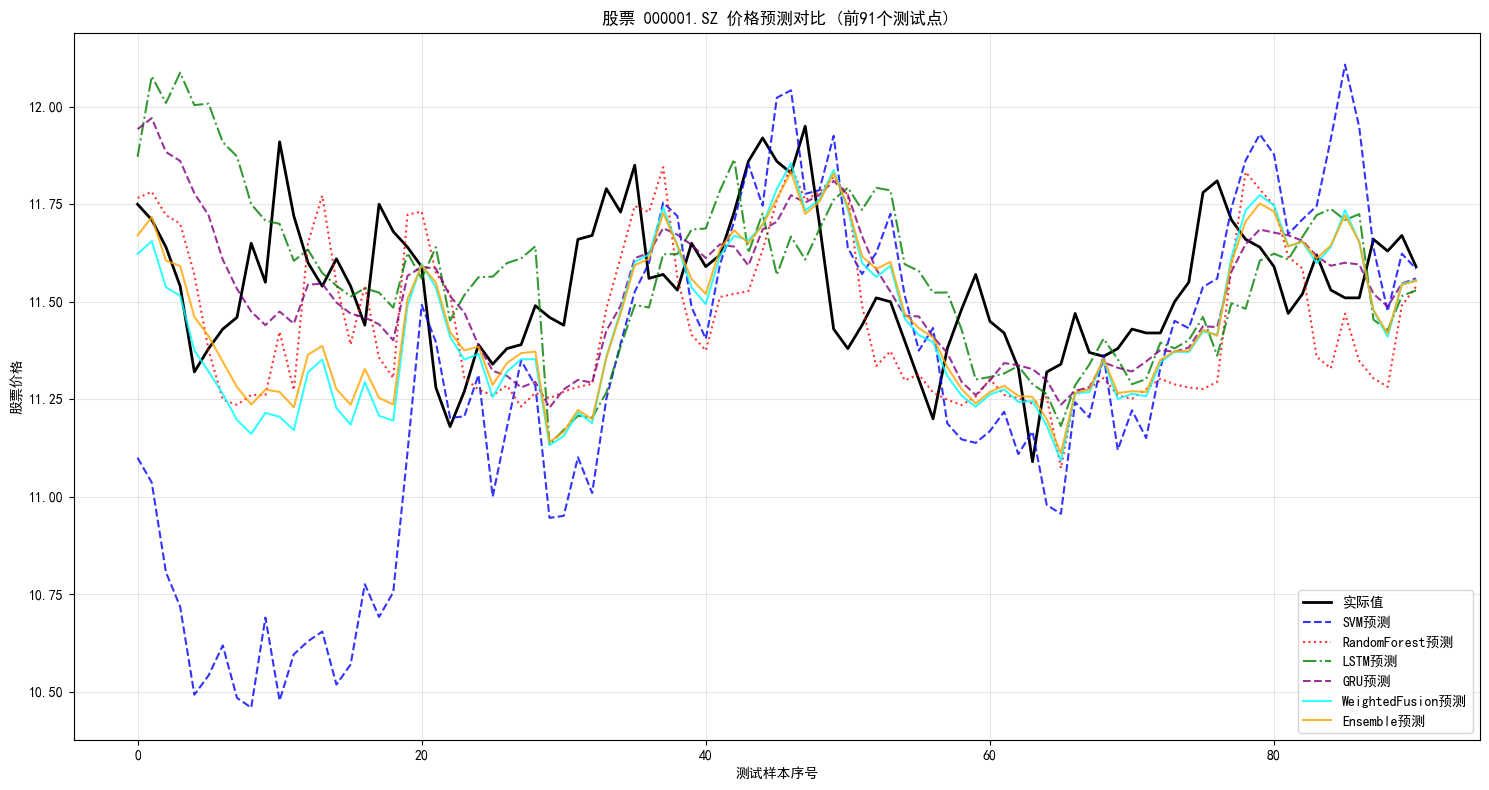

In [7]:
# 股票预测和训练类的扩展
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import time

class StockModelTrainer:
    def __init__(self, predictor):
        self.predictor = predictor
        self.models = {}
        self.model_metrics = {}
        
        # 初始化默认权重 - 已归一化
        self.fusion_weights = {
            'SVM': 0.3,
            'RandomForest': 0.3,
            'LSTM': 0.2,
            'GRU': 0.2
        }
        
    def set_fusion_weights(self, weights):
        """安全地设置融合权重，确保它们已归一化"""
        total = sum(weights.values())
        if total <= 0:
            print("警告: 权重总和必须大于0，使用默认权重")
            return
            
        self.fusion_weights = {model: weight/total for model, weight in weights.items()}
        print(f"已更新融合权重: {self.fusion_weights}")
        
    def create_sequences(self, X, y, time_steps=10):
        """创建时间序列数据"""
        X_seq, y_seq = [], []
        for i in range(len(X) - time_steps):
            X_seq.append(X[i:i + time_steps].flatten())
            y_seq.append(y[i + time_steps])
        return np.array(X_seq), np.array(y_seq)
    
    def train_all_models(self, stock_code, test_size=0.2):
        """为指定股票训练所有模型"""
        print(f"\n{'='*50}")
        print(f"开始训练股票 {stock_code} 的预测模型...")
        print(f"{'='*50}")
        
        # 准备数据
        X, y, stock_data, features = self.predictor.prepare_data(stock_code)
        if X is None:
            return None
        
        # 数据标准化
        X_scaled = self.predictor.mm_scaler.fit_transform(X)
        
        # 创建时间序列
        X_seq, y_seq = self.create_sequences(X_scaled, y.values, self.predictor.time_steps)
        
        # 数据划分
        train_size = int(len(X_seq) * (1 - test_size))
        X_train_seq = X_seq[:train_size]
        X_test_seq = X_seq[train_size:]
        y_train_seq = y_seq[:train_size]
        y_test_seq = y_seq[train_size:]
        
        # LSTM数据重塑
        X_train_lstm = X_train_seq.reshape(X_train_seq.shape[0], self.predictor.time_steps, X.shape[1])
        X_test_lstm = X_test_seq.reshape(X_test_seq.shape[0], self.predictor.time_steps, X.shape[1])
        
        # 存储数据以供后续使用
        self.current_data = {
            'X': X, 'y': y, 'stock_data': stock_data, 'features': features,
            'X_train_seq': X_train_seq, 'X_test_seq': X_test_seq,
            'y_train_seq': y_train_seq, 'y_test_seq': y_test_seq,
            'X_train_lstm': X_train_lstm, 'X_test_lstm': X_test_lstm
        }
        
        # 训练模型字典
        self.models[stock_code] = {}
        self.model_metrics[stock_code] = {}
        
        # 1. 训练SVM
        print("训练SVM模型...")
        start_time = time.time()
        svm_model = SVR(kernel='rbf', C=100, gamma=0.1)
        svm_model.fit(X_train_seq, y_train_seq)
        self.models[stock_code]['SVM'] = svm_model
        print(f"SVM训练完成，用时: {time.time() - start_time:.2f}秒")
        
        # 2. 训练随机森林
        print("训练随机森林模型...")
        start_time = time.time()
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train_seq, y_train_seq)
        self.models[stock_code]['RandomForest'] = rf_model
        print(f"随机森林训练完成，用时: {time.time() - start_time:.2f}秒")
        
        # 3. 训练LSTM
        print("训练LSTM模型...")
        start_time = time.time()
        lstm_model = Sequential([
            LSTM(100, activation='relu', return_sequences=True, input_shape=(self.predictor.time_steps, X.shape[1])),
            Dropout(0.2),
            LSTM(50, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        lstm_model.compile(optimizer='adam', loss='mse')
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lstm_model.fit(X_train_lstm, y_train_seq, epochs=50, batch_size=32, 
                      validation_split=0.1, callbacks=[early_stop], verbose=0)
        self.models[stock_code]['LSTM'] = lstm_model
        print(f"LSTM训练完成，用时: {time.time() - start_time:.2f}秒")
        
        # 4. 训练GRU
        print("训练GRU模型...")
        start_time = time.time()
        gru_model = Sequential([
            GRU(100, activation='relu', return_sequences=True, input_shape=(self.predictor.time_steps, X.shape[1])),
            Dropout(0.2),
            GRU(50, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])
        gru_model.compile(optimizer='adam', loss='mse')
        gru_model.fit(X_train_lstm, y_train_seq, epochs=50, batch_size=32,
                     validation_split=0.1, callbacks=[early_stop], verbose=0)
        self.models[stock_code]['GRU'] = gru_model
        print(f"GRU训练完成，用时: {time.time() - start_time:.2f}秒")
        
        # 5. 创建权重融合模型
        print("创建加权融合模型...")
        print(f"当前融合权重: {self.fusion_weights}")
        start_time = time.time()
        
        # 创建一个权重融合预测器类
        class WeightedEnsemble:
            def __init__(self, models, weights, input_shape):
                self.models = models
                self.weights = weights
                self.input_shape = input_shape
                print(f"融合模型初始化，权重: {weights}")
                
            def predict(self, X):
                # 根据输入数据形状判断应该使用哪种输入格式
                predictions = []
                for model_name, model in self.models.items():
                    if model_name in ['LSTM', 'GRU']:
                        # 重塑数据以适应RNN模型
                        X_reshaped = X.reshape(X.shape[0], self.input_shape[0], self.input_shape[1]) \
                                     if len(X.shape) == 2 else X
                        pred = model.predict(X_reshaped, verbose=0).flatten()
                    else:
                        # 保持原始形状用于传统模型
                        pred = model.predict(X)
                        
                    predictions.append(self.weights[model_name] * pred)
                
                # 返回加权平均预测
                return np.sum(predictions, axis=0)
        
        # 实例化加权融合模型
        fusion_model = WeightedEnsemble(
            models={k: self.models[stock_code][k] for k in self.fusion_weights.keys()},
            weights=self.fusion_weights,
            input_shape=(self.predictor.time_steps, X.shape[1])
        )
        
        self.models[stock_code]['WeightedFusion'] = fusion_model
        print(f"加权融合模型创建完成，用时: {time.time() - start_time:.2f}秒")
        print(f"融合权重: SVM={self.fusion_weights['SVM']}, RandomForest={self.fusion_weights['RandomForest']}, "
              f"LSTM={self.fusion_weights['LSTM']}, GRU={self.fusion_weights['GRU']}")
        
        # 评估所有模型
        self.evaluate_models(stock_code)
        
        return self.models[stock_code]
    
    def evaluate_models(self, stock_code):
        """评估模型性能"""
        print(f"\n评估股票 {stock_code} 的模型性能:")
        print("-" * 60)
        
        data = self.current_data
        results = {}
        
        # 获取预测结果
        svm_pred = self.models[stock_code]['SVM'].predict(data['X_test_seq'])
        rf_pred = self.models[stock_code]['RandomForest'].predict(data['X_test_seq'])
        lstm_pred = self.models[stock_code]['LSTM'].predict(data['X_test_lstm']).flatten()
        gru_pred = self.models[stock_code]['GRU'].predict(data['X_test_lstm']).flatten()
        
        # 加权融合模型预测
        weighted_pred = self.models[stock_code]['WeightedFusion'].predict(data['X_test_seq'])
        
        # 简单平均融合预测
        ensemble_pred = (0.25 * svm_pred + 0.25 * rf_pred + 0.25 * lstm_pred + 0.25 * gru_pred)
        
        # 评估每个模型
        models_pred = {
            'SVM': svm_pred,
            'RandomForest': rf_pred,
            'LSTM': lstm_pred,
            'GRU': gru_pred,
            'WeightedFusion': weighted_pred,
            'Ensemble': ensemble_pred
        }
        
        for model_name, pred in models_pred.items():
            mse = mean_squared_error(data['y_test_seq'], pred)
            mae = mean_absolute_error(data['y_test_seq'], pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(data['y_test_seq'], pred)
            
            results[model_name] = {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'R2': r2}
            
            print(f"{model_name:12} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
        
        self.model_metrics[stock_code] = results
        
        # 可视化预测结果
        self.plot_predictions(stock_code, data['y_test_seq'], models_pred)
        
        return results
    
    def plot_predictions(self, stock_code, y_true, predictions):
        """绘制预测结果"""
        plt.figure(figsize=(15, 8))
        
        # 只显示前100个测试点以保持图表清晰
        n_points = min(100, len(y_true))
        x_range = range(n_points)
        
        plt.plot(x_range, y_true[:n_points], label='实际值', color='black', linewidth=2)
        
        colors = ['blue', 'red', 'green', 'purple', 'cyan', 'orange']
        linestyles = ['--', ':', '-.', '--', '-', '-']
        
        for i, (model_name, pred) in enumerate(predictions.items()):
            plt.plot(x_range, pred[:n_points], 
                    label=f'{model_name}预测', 
                    color=colors[i % len(colors)], 
                    linestyle=linestyles[i % len(linestyles)],
                    alpha=0.8)
        
        plt.title(f'股票 {stock_code} 价格预测对比 (前{n_points}个测试点)')
        plt.xlabel('测试样本序号')
        plt.ylabel('股票价格')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{stock_code}_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

# 创建模型训练器
trainer = StockModelTrainer(predictor)

# 用户选择股票进行预测
print("\n请选择要预测的股票:")
print("1. 输入具体股票代码 (如: 000001.SZ)")
print("2. 选择多只股票进行批量预测")

# 示例：预测第一只股票
selected_stock = predictor.stock_codes[0]
print(f"\n开始预测股票: {selected_stock}")
models = trainer.train_all_models(selected_stock)


演示：预测前3只股票

正在预测股票: 000001.SZ

开始训练股票 000001.SZ 的预测模型...
正在处理股票 000001.SZ 的数据...
数据准备完成，共 462 个样本
训练SVM模型...
SVM训练完成，用时: 0.02秒
训练随机森林模型...
随机森林训练完成，用时: 1.74秒
训练LSTM模型...
随机森林训练完成，用时: 1.74秒
训练LSTM模型...
LSTM训练完成，用时: 6.29秒
训练GRU模型...
LSTM训练完成，用时: 6.29秒
训练GRU模型...
GRU训练完成，用时: 6.71秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000001.SZ 的模型性能:
------------------------------------------------------------
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/stepGRU训练完成，用时: 6.71秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000001.SZ 的模型性能:
------------------------------------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000233DD23AF20> triggered tf.function retracing. Tracing is expensive 

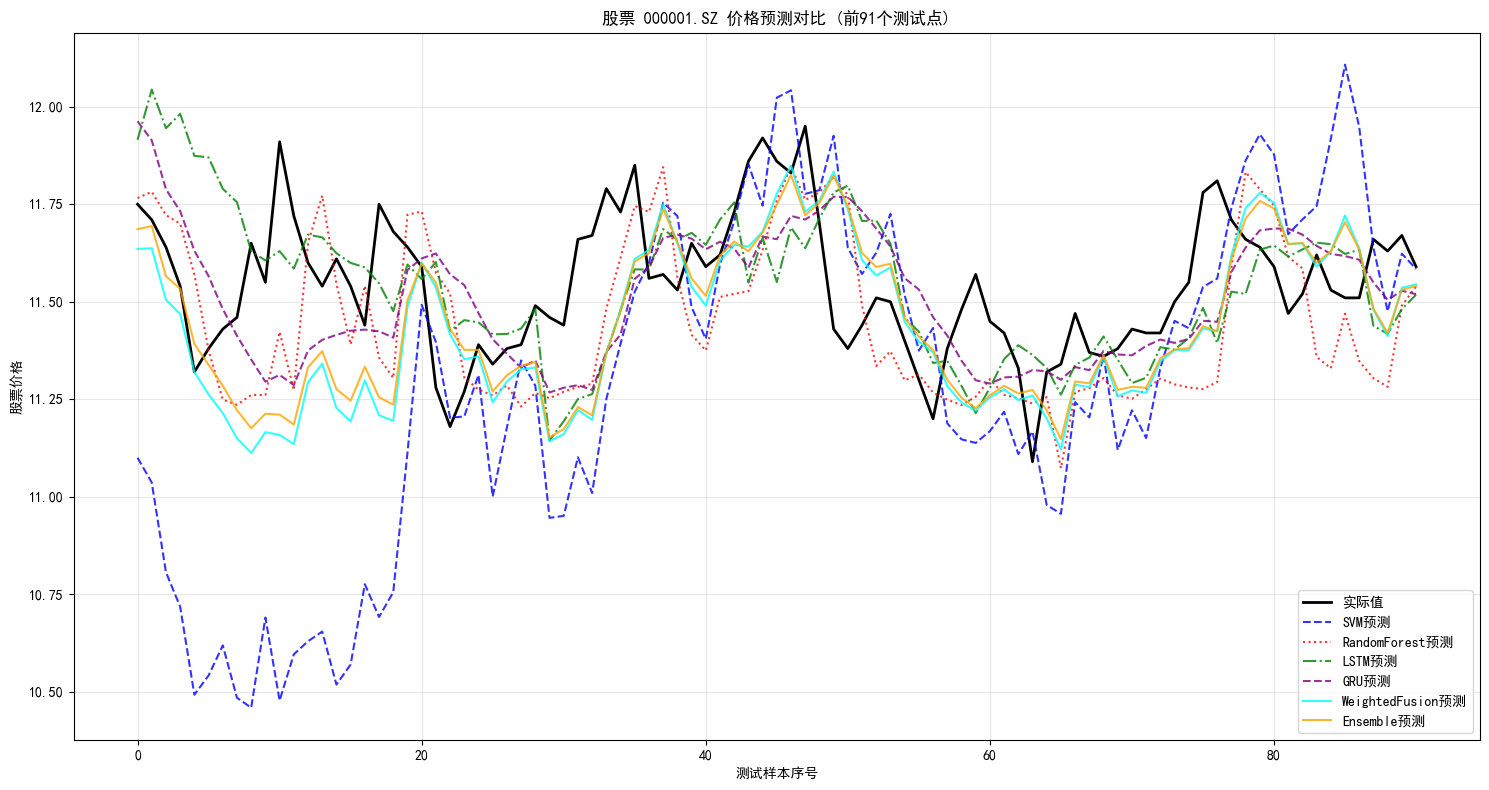


正在预测股票: 000002.SZ

开始训练股票 000002.SZ 的预测模型...
正在处理股票 000002.SZ 的数据...
数据准备完成，共 462 个样本
训练SVM模型...
SVM训练完成，用时: 0.02秒
训练随机森林模型...
随机森林训练完成，用时: 1.66秒
训练LSTM模型...
随机森林训练完成，用时: 1.66秒
训练LSTM模型...
LSTM训练完成，用时: 6.91秒
训练GRU模型...
LSTM训练完成，用时: 6.91秒
训练GRU模型...
GRU训练完成，用时: 6.62秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000002.SZ 的模型性能:
------------------------------------------------------------
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/stepGRU训练完成，用时: 6.62秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000002.SZ 的模型性能:
------------------------------------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000233E74B85E0> triggered tf.function retracing. Tracing is expensive and the exce

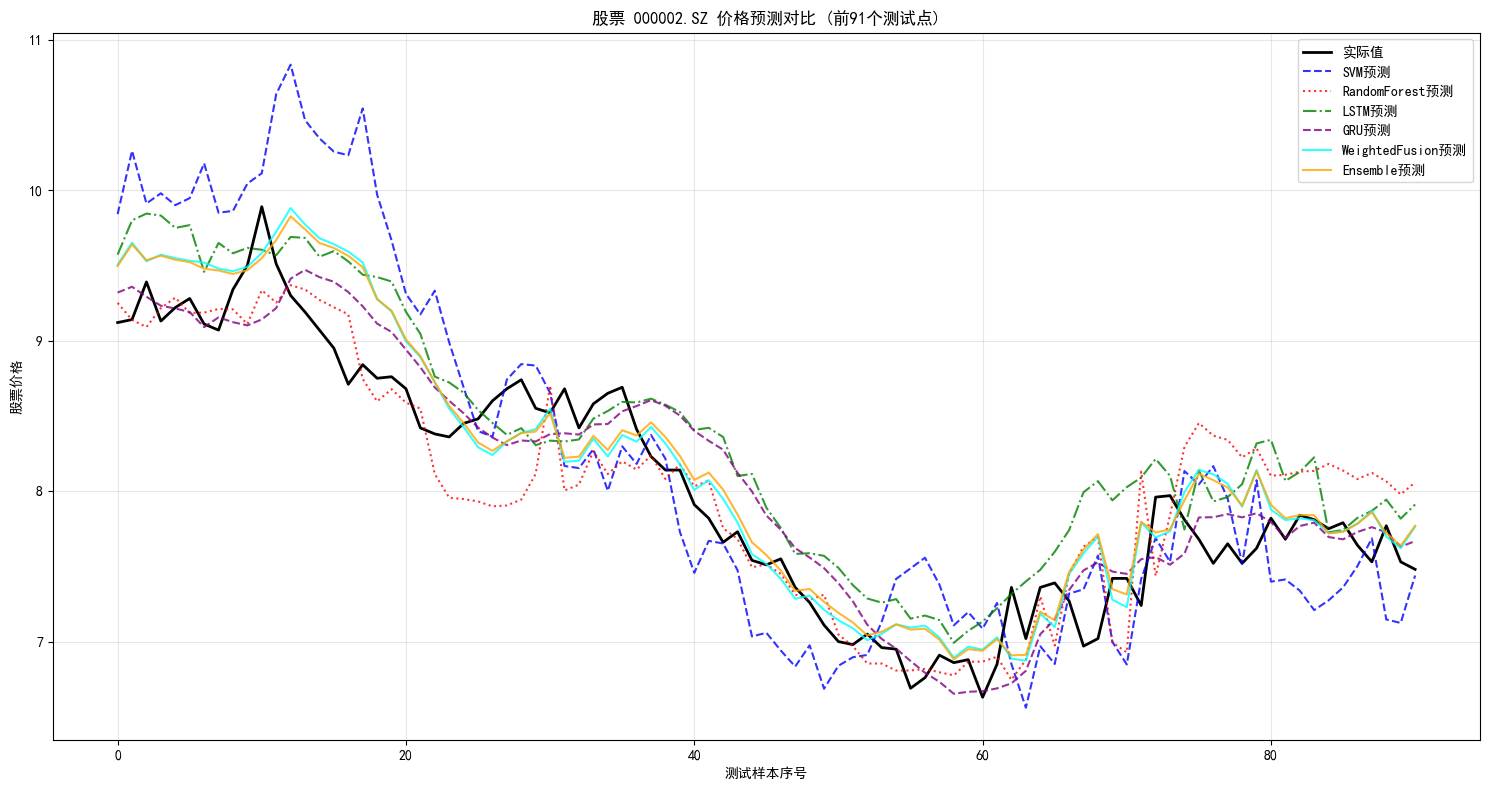


正在预测股票: 000004.SZ

开始训练股票 000004.SZ 的预测模型...
正在处理股票 000004.SZ 的数据...
数据准备完成，共 461 个样本
训练SVM模型...
SVM训练完成，用时: 0.02秒
训练随机森林模型...
随机森林训练完成，用时: 1.72秒
训练LSTM模型...
随机森林训练完成，用时: 1.72秒
训练LSTM模型...
LSTM训练完成，用时: 3.84秒
训练GRU模型...
LSTM训练完成，用时: 3.84秒
训练GRU模型...
GRU训练完成，用时: 3.90秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000004.SZ 的模型性能:
------------------------------------------------------------
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/stepGRU训练完成，用时: 3.90秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000004.SZ 的模型性能:
------------------------------------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
SVM          - MSE: 4.7049, MAE: 1.7545, RMSE: 2.1691, R²: 0.5778
RandomForest - MSE: 1.6256, MAE: 1.0148, RMSE: 1.2750, R²: 0.8541
LSTM         - MSE: 5.4086, MAE: 1.8746, RMSE: 2.3256, R

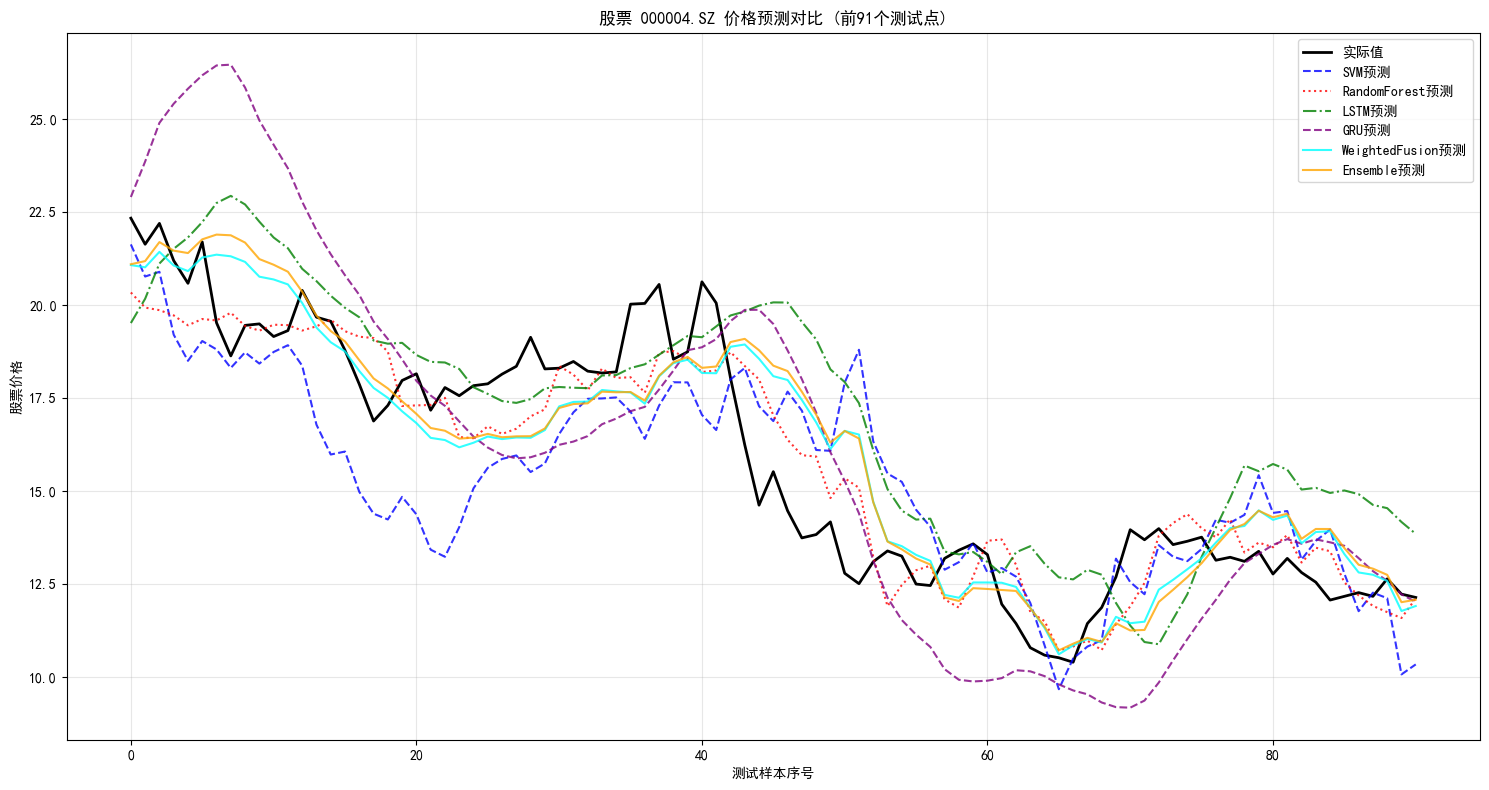

In [3]:
# 交互式股票选择和预测功能
class InteractiveStockPredictor:
    def __init__(self, trainer):
        self.trainer = trainer
        self.predictor = trainer.predictor
        
    def interactive_predict(self):
        """交互式股票预测"""
        while True:
            print(f"\n{'='*60}")
            print("股票预测系统")
            print(f"{'='*60}")
            print("1. 查看可用股票列表")
            print("2. 预测单只股票")
            print("3. 批量预测多只股票")
            print("4. 预测未来价格")
            print("5. 退出")
            
            choice = input("\n请选择操作 (1-5): ").strip()
            
            if choice == '1':
                self.show_stock_list()
            elif choice == '2':
                self.single_stock_predict()
            elif choice == '3':
                self.batch_predict()
            elif choice == '4':
                self.future_predict()
            elif choice == '5':
                print("退出系统")
                break
            else:
                print("无效选择，请重新输入")
    
    def show_stock_list(self):
        """显示可用的股票列表(优化版-分页显示)"""
        # 创建股票列表窗口
        list_window = tk.Toplevel(self.root)
        list_window.title("可用股票列表")
        list_window.geometry("600x450")  # 增加窗口高度以容纳分页控件
        list_window.transient(self.root)
        
        # 在窗口顶部添加筛选框架
        filter_frame = ttk.Frame(list_window, padding="5")
        filter_frame.pack(fill=tk.X, padx=5, pady=5)
        
        # 添加搜索框
        ttk.Label(filter_frame, text="搜索:").pack(side=tk.LEFT, padx=5)
        search_var = tk.StringVar()
        search_entry = ttk.Entry(filter_frame, textvariable=search_var, width=15)
        search_entry.pack(side=tk.LEFT, padx=5)
        
        # 分页控制变量
        page_size = 20  # 每页显示的股票数量
        current_page = 0  # 当前页，从0开始
        total_pages = (len(self.predictor.stock_codes) + page_size - 1) // page_size  # 总页数(向上取整)
        
        # 创建树形视图
        columns = ("序号", "股票代码", "开始日期", "结束日期")
        tree = ttk.Treeview(list_window, columns=columns, show="headings")
        
        # 定义列
        for col in columns:
            tree.heading(col, text=col)
        
        tree.column("序号", width=50)
        tree.column("股票代码", width=150)
        tree.column("开始日期", width=150)
        tree.column("结束日期", width=150)
        
        # 添加滚动条
        scrollbar = ttk.Scrollbar(list_window, orient="vertical", command=tree.yview)
        tree.configure(yscrollcommand=scrollbar.set)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        tree.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=5, pady=5)
        
        # 分页控制框架
        page_frame = ttk.Frame(list_window, padding="5")
        page_frame.pack(fill=tk.X, padx=5, pady=5)
        
        # 页面信息标签
        page_info = ttk.Label(page_frame, text=f"第 {current_page+1} 页,共 {total_pages} 页")
        page_info.pack(side=tk.LEFT, padx=10)
        
        # 定义加载指定页数据的函数
        def load_page_data(page=0, search_text=""):
            # 清空当前树
            for item in tree.get_children():
                tree.delete(item)
            
            # 如果有搜索文本，筛选股票代码
            if search_text:
                filtered_codes = [code for code in self.predictor.stock_codes if search_text.upper() in code]
                codes_to_show = filtered_codes
                new_total_pages = (len(filtered_codes) + page_size - 1) // page_size
                page_info.config(text=f"筛选结果: {len(filtered_codes)} 只股票, 第 {page+1} 页,共 {new_total_pages} 页")
            else:
                codes_to_show = self.predictor.stock_codes
                page_info.config(text=f"第 {page+1} 页,共 {total_pages} 页")
            
            # 计算显示的股票范围
            start_idx = page * page_size
            end_idx = min(start_idx + page_size, len(codes_to_show))
            
            # 填充数据 (使用批量查询而不是逐个查询)
            batch_codes = codes_to_show[start_idx:end_idx]
            # 构建缓存以减少重复查询
            code_data_cache = {}
            for code_batch in [batch_codes[i:i+5] for i in range(0, len(batch_codes), 5)]:
                # 每次处理5个代码，减少内存压力
                batch_filter = self.predictor.df['ts_code'].isin(code_batch)
                batch_data = self.predictor.df[batch_filter]
                
                for code in code_batch:
                    stock_data = batch_data[batch_data['ts_code'] == code]
                    if not stock_data.empty:
                        code_data_cache[code] = {
                            'start': stock_data['trade_date'].min().date(),
                            'end': stock_data['trade_date'].max().date()
                        }
            
            # 填充树形视图
            for i, code in enumerate(batch_codes):
                if code in code_data_cache:
                    data = code_data_cache[code]
                    tree.insert("", tk.END, values=(
                        i + start_idx + 1,  # 序号
                        code,               # 股票代码
                        data['start'],      # 开始日期
                        data['end']         # 结束日期
                    ))
        
        # 首次加载第一页数据
        load_page_data(current_page)
        
        # 上一页按钮
        def prev_page():
            nonlocal current_page
            if current_page > 0:
                current_page -= 1
                load_page_data(current_page, search_var.get())
        
        # 下一页按钮
        def next_page():
            nonlocal current_page
            search_text = search_var.get()
            max_pages = total_pages
            if search_text:
                filtered_codes = [code for code in self.predictor.stock_codes if search_text.upper() in code]
                max_pages = (len(filtered_codes) + page_size - 1) // page_size
            
            if current_page < max_pages - 1:
                current_page += 1
                load_page_data(current_page, search_text)
        
        # 搜索功能
        def on_search(*args):
            nonlocal current_page
            current_page = 0  # 重置到第一页
            load_page_data(current_page, search_var.get())
        
        # 绑定搜索事件
        search_var.trace("w", on_search)  # 输入变化时自动搜索
        
        # 添加分页按钮
        ttk.Button(page_frame, text="上一页", command=prev_page).pack(side=tk.LEFT, padx=10)
        ttk.Button(page_frame, text="下一页", command=next_page).pack(side=tk.LEFT, padx=10)
        
        # 添加双击选择功能
        def on_item_double_click(event):
            item = tree.selection()[0]
            code = tree.item(item, "values")[1]
            self.stock_code_entry.delete(0, tk.END)
            self.stock_code_entry.insert(0, code)
            list_window.destroy()
        
        tree.bind("<Double-1>", on_item_double_click)
        
        # 添加页码跳转功能
        jump_frame = ttk.Frame(page_frame)
        jump_frame.pack(side=tk.RIGHT, padx=10)
        
        ttk.Label(jump_frame, text="跳转到:").pack(side=tk.LEFT)
        jump_var = tk.StringVar()
        jump_entry = ttk.Entry(jump_frame, textvariable=jump_var, width=5)
        jump_entry.pack(side=tk.LEFT, padx=5)
        
        def jump_to_page():
            nonlocal current_page
            try:
                target_page = int(jump_var.get()) - 1  # 用户输入从1开始，但内部从0开始
                if 0 <= target_page < total_pages:
                    current_page = target_page
                    load_page_data(current_page, search_var.get())
                else:
                    messagebox.showwarning("警告", f"页码超出范围 (1-{total_pages})")
            except ValueError:
                messagebox.showwarning("警告", "请输入有效的页码")
        
        ttk.Button(jump_frame, text="确定", command=jump_to_page).pack(side=tk.LEFT, padx=5)
        
        # 添加关闭按钮
        ttk.Button(list_window, text="关闭", command=list_window.destroy).pack(pady=10)
        
        # 聚焦搜索框
        search_entry.focus_set()

    def single_stock_predict(self):
        """单只股票预测"""
        stock_code = input("请输入股票代码: ").strip().upper()
        
        if self.predictor.validate_stock_code(stock_code):
            models = self.trainer.train_all_models(stock_code)
            if models:
                print(f"\n股票 {stock_code} 的预测模型训练完成!")
    
    def batch_predict(self):
        """批量预测"""
        stock_codes_input = input("请输入股票代码，用逗号分隔: ").strip()
        stock_codes = [code.strip().upper() for code in stock_codes_input.split(',')]
        
        results_summary = {}
        
        for stock_code in stock_codes:
            if self.predictor.validate_stock_code(stock_code):
                try:
                    models = self.trainer.train_all_models(stock_code)
                    if models:
                        results_summary[stock_code] = self.trainer.model_metrics[stock_code]
                        print(f"✓ 股票 {stock_code} 预测完成")
                except Exception as e:
                    print(f"✗ 股票 {stock_code} 预测失败: {str(e)}")
            else:
                print(f"✗ 跳过无效股票代码: {stock_code}")
        
        # 显示批量预测汇总
        if results_summary:
            self.show_batch_summary(results_summary)
    
    def show_batch_summary(self, results_summary):
        """显示批量预测汇总"""
        print(f"\n{'='*80}")
        print("批量预测结果汇总")
        print(f"{'='*80}")
        
        print(f"{'股票代码':<12} {'最佳模型':<15} {'R²得分':<10} {'RMSE':<10}")
        print("-" * 80)
        
        for stock_code, metrics in results_summary.items():
            # 找到R²得分最高的模型
            best_model = max(metrics.items(), key=lambda x: x[1]['R2'])
            model_name, model_metrics = best_model
            
            print(f"{stock_code:<12} {model_name:<15} {model_metrics['R2']:<10.4f} {model_metrics['RMSE']:<10.4f}")
    
    def future_predict(self):
        """未来价格预测"""
        stock_code = input("请输入要预测未来价格的股票代码: ").strip().upper()
        
        if stock_code not in self.trainer.models:
            print(f"请先训练股票 {stock_code} 的模型")
            return
        
        days = int(input("预测未来多少天? (默认5天): ").strip() or "5")
        
        # 获取最后一批数据
        X, y, stock_data, features = self.predictor.prepare_data(stock_code)
        if X is None:
            return
        
        last_batch = X.iloc[-self.predictor.time_steps:].reset_index(drop=True)
        
        # 预测未来价格
        models = self.trainer.models[stock_code]
        future_predictions = {}
        
        for model_name, model in models.items():
            if model_name in ['LSTM', 'GRU']:
                future_pred = self.predict_future_rnn(model, last_batch, days)
            elif model_name == 'WeightedFusion':
                # 对于融合模型，我们使用特殊处理
                future_pred = self.predict_future_fusion(model, last_batch, days)
            else:
                future_pred = self.predict_future_traditional(model, last_batch, days)
            future_predictions[model_name] = future_pred
        
        # 简单平均融合预测
        ensemble_pred = []
        for i in range(days):
            # 只融合基础模型，不包括WeightedFusion和Ensemble
            base_models = ['SVM', 'RandomForest', 'LSTM', 'GRU']
            day_pred = np.mean([future_predictions[m][i] for m in base_models])
            ensemble_pred.append(day_pred)
        future_predictions['Ensemble'] = ensemble_pred
        
        # 显示和可视化结果
        self.show_future_predictions(stock_code, future_predictions, days)
    
    def predict_future_traditional(self, model, last_data, days):
        """传统模型未来预测"""
        future_pred = []
        scaled_data = self.predictor.mm_scaler.transform(last_data)
        n_features = last_data.shape[1]
        
        current_seq = scaled_data.reshape(1, self.predictor.time_steps * n_features)
        
        for _ in range(days):
            next_pred = model.predict(current_seq)[0]
            future_pred.append(float(next_pred))
            
            # 更新序列
            flat_seq = current_seq.flatten()[n_features:].copy()
            new_features = flat_seq[-n_features:].copy()
            new_features[0] = next_pred
            updated_seq = np.append(flat_seq, new_features)[-self.predictor.time_steps*n_features:]
            current_seq = updated_seq.reshape(1, -1)
        
        return future_pred
    
    def predict_future_rnn(self, model, last_data, days):
        """RNN模型未来预测"""
        future_pred = []
        scaled_data = self.predictor.mm_scaler.transform(last_data)
        n_features = last_data.shape[1]
        
        current_seq = scaled_data.reshape(1, self.predictor.time_steps, n_features)
        
        for _ in range(days):
            next_pred = model.predict(current_seq, verbose=0)[0, 0]
            future_pred.append(float(next_pred))
            
            # 更新序列
            shifted_data = scaled_data[1:].copy()
            new_step = scaled_data[-1:].copy()
            new_step[0, 0] = next_pred
            scaled_data = np.vstack([shifted_data, new_step])
            current_seq = scaled_data.reshape(1, self.predictor.time_steps, n_features)
        
        return future_pred
    
    def predict_future_fusion(self, fusion_model, last_data, days):
        """融合模型未来预测"""
        future_pred = []
        scaled_data = self.predictor.mm_scaler.transform(last_data)
        n_features = last_data.shape[1]
        
        current_seq = scaled_data.reshape(1, self.predictor.time_steps * n_features)
        
        for _ in range(days):
            next_pred = fusion_model.predict(current_seq)[0]
            future_pred.append(float(next_pred))
            
            # 更新序列
            flat_seq = current_seq.flatten()[n_features:].copy()
            new_features = flat_seq[-n_features:].copy()
            new_features[0] = next_pred
            updated_seq = np.append(flat_seq, new_features)[-self.predictor.time_steps*n_features:]
            current_seq = updated_seq.reshape(1, -1)
        
        return future_pred
    
    def show_future_predictions(self, stock_code, predictions, days):
        """显示未来预测结果"""
        # 创建未来日期
        last_date = pd.Timestamp.now().date()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days, freq='D')
        
        # 创建预测DataFrame
        future_df = pd.DataFrame({'日期': future_dates})
        for model_name, pred in predictions.items():
            future_df[f'{model_name}预测'] = pred
        
        print(f"\n股票 {stock_code} 未来 {days} 天价格预测:")
        print(future_df.to_string(index=False))
        
        # 可视化
        plt.figure(figsize=(12, 6))
        # 使用带有高对比度的颜色和不同的线型让图表更易读
        colors = ['blue', 'red', 'green', 'purple', 'cyan', 'orange']
        linestyles = ['--', ':', '-.', '--', '-', '-']
        
        models_to_plot = list(predictions.keys())
        
        for i, model_name in enumerate(models_to_plot):
            plt.plot(future_dates, predictions[model_name], 'o-', 
                    label=f'{model_name}预测', 
                    color=colors[i % len(colors)],
                    linestyle=linestyles[i % len(linestyles)],
                    alpha=0.8)
        
        plt.title(f'股票 {stock_code} 未来 {days} 天价格预测')
        plt.xlabel('日期')
        plt.ylabel('预测价格')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'{stock_code}_future_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()

# 创建交互式预测器
interactive_predictor = InteractiveStockPredictor(trainer)

# 启动交互式预测（注释掉避免在Notebook中无限循环）
# interactive_predictor.interactive_predict()

# 演示功能：预测多只股票
print("\n演示：预测前3只股票")
demo_stocks = predictor.stock_codes[:3]
for stock in demo_stocks:
    try:
        print(f"\n正在预测股票: {stock}")
        trainer.train_all_models(stock)
    except Exception as e:
        print(f"预测股票 {stock} 时出错: {str(e)}")

演示股票筛选功能（可能需要一些时间）...
正在筛选R²得分高于 0.3 的股票...
测试股票 000001.SZ...
正在处理股票 000001.SZ 的数据...
数据准备完成，共 462 个样本
✗ 000001.SZ: R² = -0.6700 (低于阈值)
测试股票 000002.SZ...
正在处理股票 000002.SZ 的数据...
数据准备完成，共 462 个样本
✗ 000001.SZ: R² = -0.6700 (低于阈值)
测试股票 000002.SZ...
正在处理股票 000002.SZ 的数据...
数据准备完成，共 462 个样本
✓ 000002.SZ: R² = 0.7873
测试股票 000004.SZ...
正在处理股票 000004.SZ 的数据...
数据准备完成，共 461 个样本
✓ 000002.SZ: R² = 0.7873
测试股票 000004.SZ...
正在处理股票 000004.SZ 的数据...
数据准备完成，共 461 个样本
✓ 000004.SZ: R² = 0.8575
测试股票 000006.SZ...
正在处理股票 000006.SZ 的数据...
数据准备完成，共 462 个样本
✓ 000004.SZ: R² = 0.8575
测试股票 000006.SZ...
正在处理股票 000006.SZ 的数据...
数据准备完成，共 462 个样本
✗ 000006.SZ: R² = -3.0034 (低于阈值)
测试股票 000007.SZ...
正在处理股票 000007.SZ 的数据...
数据准备完成，共 460 个样本
✗ 000006.SZ: R² = -3.0034 (低于阈值)
测试股票 000007.SZ...
正在处理股票 000007.SZ 的数据...
数据准备完成，共 460 个样本
✗ 000007.SZ: R² = -2.0596 (低于阈值)
测试股票 000008.SZ...
正在处理股票 000008.SZ 的数据...
数据准备完成，共 462 个样本
✗ 000007.SZ: R² = -2.0596 (低于阈值)
测试股票 000008.SZ...
正在处理股票 000008.SZ 的数据...
数据准备完成，共 462 个样本
✗ 000008.

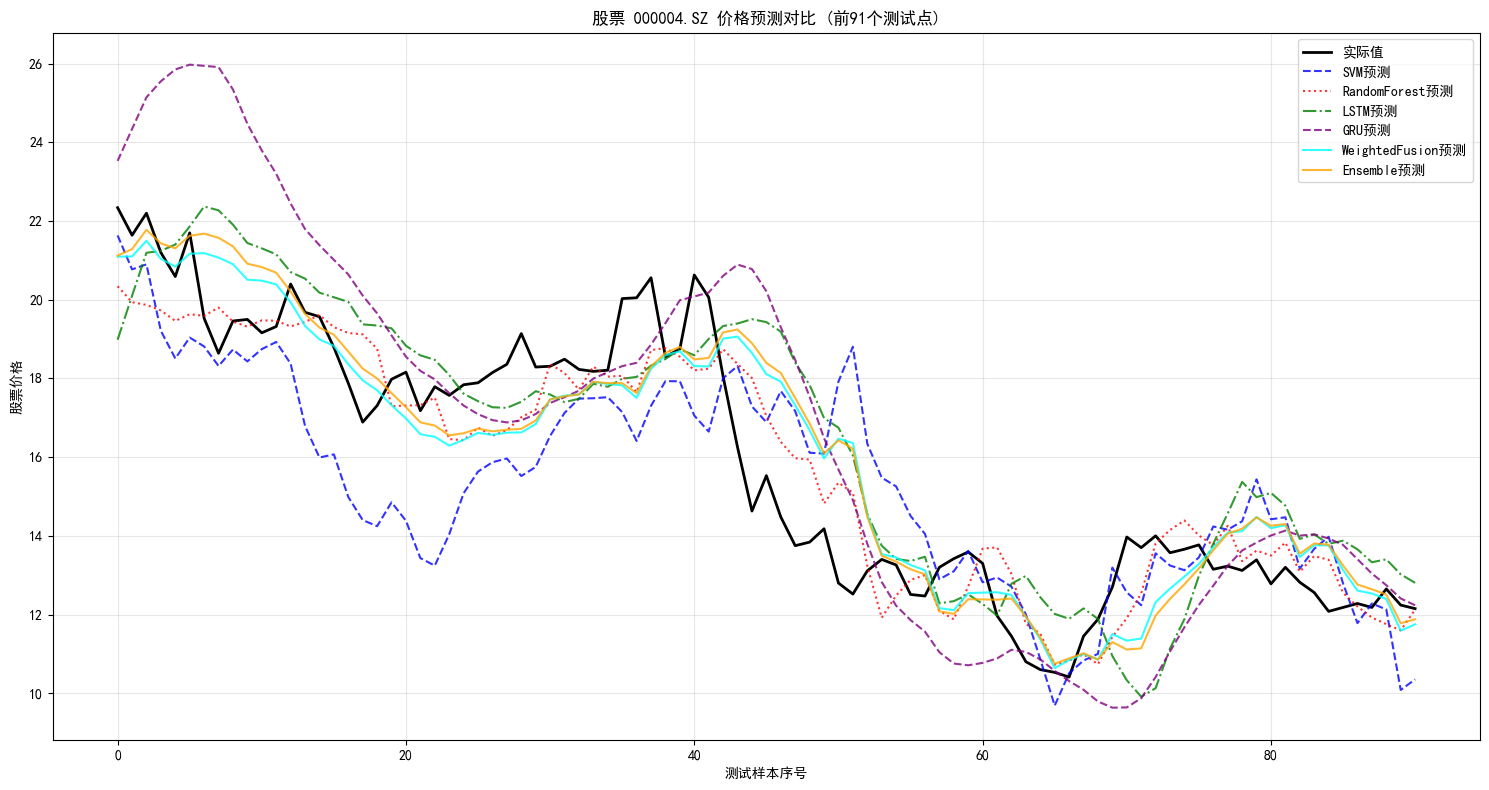


开始训练股票 000012.SZ 的预测模型...
正在处理股票 000012.SZ 的数据...
数据准备完成，共 462 个样本
训练SVM模型...
SVM训练完成，用时: 0.01秒
训练随机森林模型...
随机森林训练完成，用时: 1.69秒
训练LSTM模型...
随机森林训练完成，用时: 1.69秒
训练LSTM模型...
LSTM训练完成，用时: 7.19秒
训练GRU模型...
LSTM训练完成，用时: 7.19秒
训练GRU模型...
GRU训练完成，用时: 6.65秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000012.SZ 的模型性能:
------------------------------------------------------------
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/stepGRU训练完成，用时: 6.65秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000012.SZ 的模型性能:
------------------------------------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
SVM          - MSE: 0.0193, MAE: 0.1095, RMSE: 0.1389, R²: 0.7383
RandomForest - MSE: 0.0119, MAE: 0.0837, RMSE: 0.1089, R²: 0.8392
LSTM         - MSE: 0.0212, MAE: 0.1075, RMSE: 0.1456, R²: 0.7126
GRU      

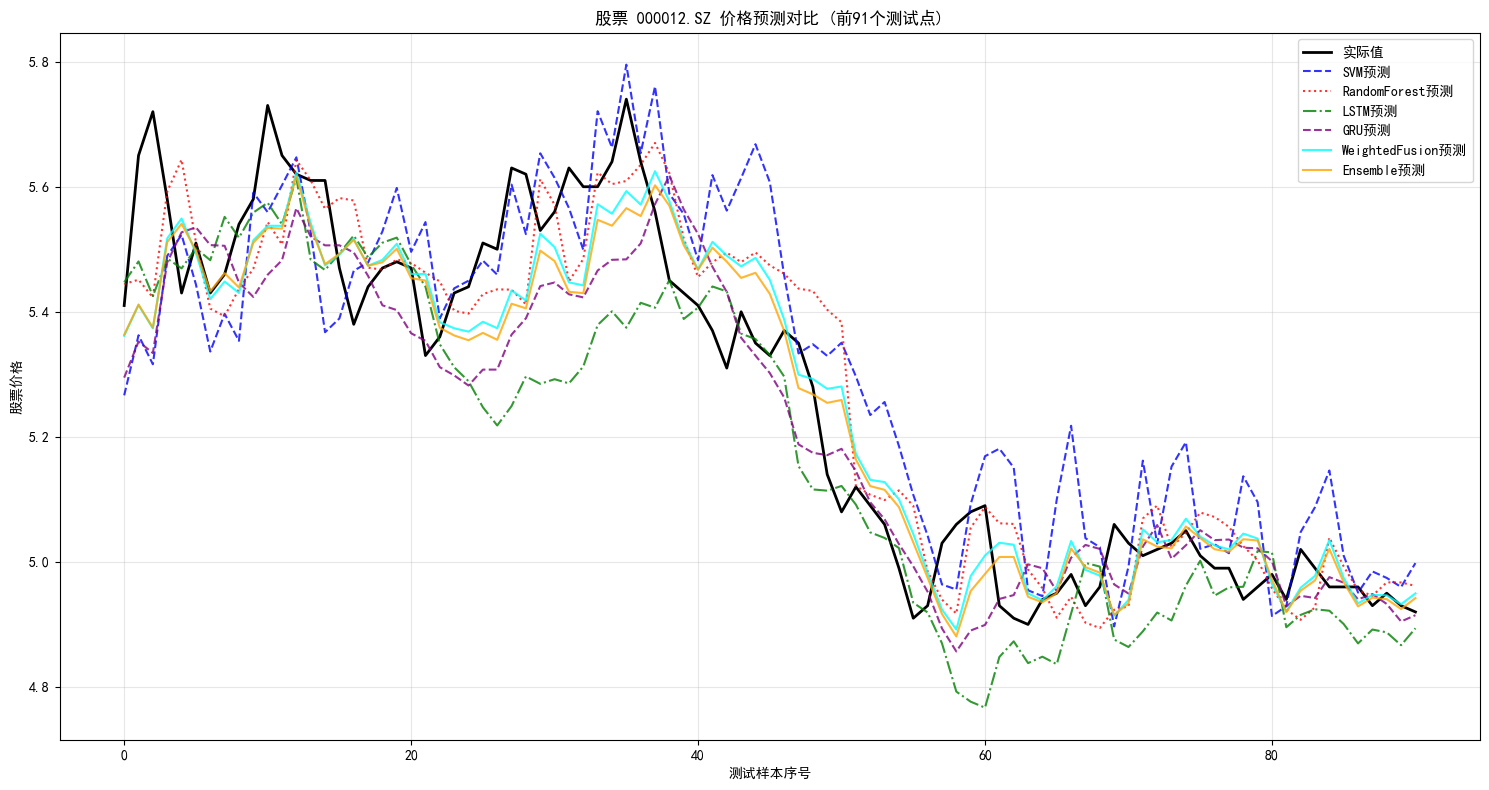


开始训练股票 000002.SZ 的预测模型...
正在处理股票 000002.SZ 的数据...
数据准备完成，共 462 个样本
训练SVM模型...
SVM训练完成，用时: 0.02秒
训练随机森林模型...
随机森林训练完成，用时: 1.66秒
训练LSTM模型...
随机森林训练完成，用时: 1.66秒
训练LSTM模型...
LSTM训练完成，用时: 5.12秒
训练GRU模型...
LSTM训练完成，用时: 5.12秒
训练GRU模型...
GRU训练完成，用时: 7.14秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000002.SZ 的模型性能:
------------------------------------------------------------
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/stepGRU训练完成，用时: 7.14秒
创建加权融合模型...
加权融合模型创建完成，用时: 0.00秒
融合权重: SVM=0.3, RandomForest=0.3, LSTM=0.2, GRU=0.2

评估股票 000002.SZ 的模型性能:
------------------------------------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
SVM          - MSE: 0.3832, MAE: 0.5026, RMSE: 0.6190, R²: 0.4191
RandomForest - MSE: 0.1469, MAE: 0.2994, RMSE: 0.3832, R²: 0.7774
LSTM         - MSE: 0.1573, MAE: 0.2837, RMSE: 0.3966, R²: 0.7616
GRU      

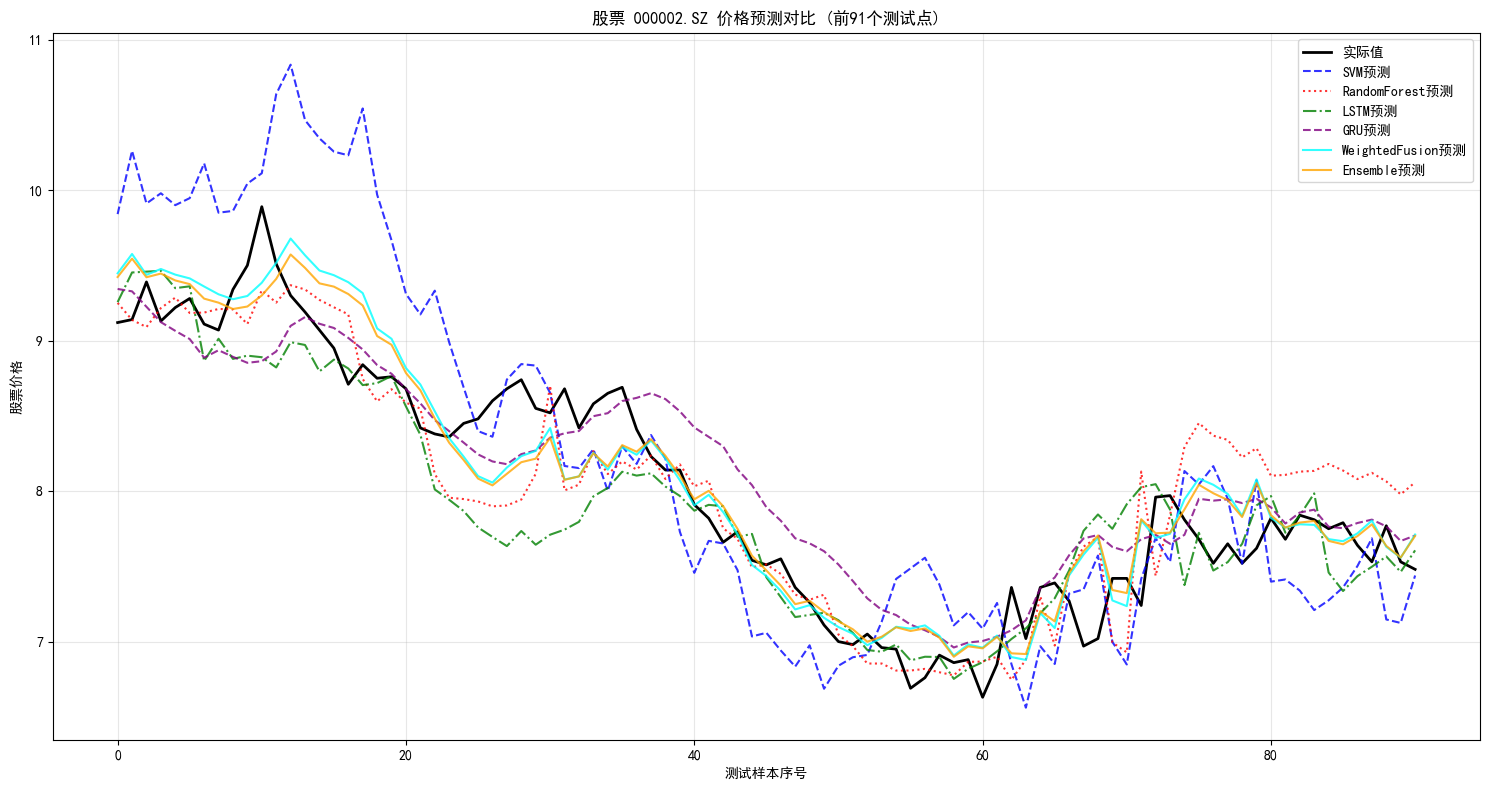


股票预测性能比较报告

SVM 模型性能比较:
股票代码         MSE        MAE        RMSE       R²        
------------------------------------------------------------
000012.SZ    0.0193     0.1095     0.1389     0.7383    
000004.SZ    4.7049     1.7545     2.1691     0.5778    
000002.SZ    0.3832     0.5026     0.6190     0.4191    

RandomForest 模型性能比较:
股票代码         MSE        MAE        RMSE       R²        
------------------------------------------------------------
000004.SZ    1.6256     1.0148     1.2750     0.8541    
000012.SZ    0.0119     0.0837     0.1089     0.8392    
000002.SZ    0.1469     0.2994     0.3832     0.7774    

LSTM 模型性能比较:
股票代码         MSE        MAE        RMSE       R²        
------------------------------------------------------------
000002.SZ    0.1573     0.2837     0.3966     0.7616    
000012.SZ    0.0212     0.1075     0.1456     0.7126    
000004.SZ    3.9507     1.6043     1.9876     0.6454    

GRU 模型性能比较:
股票代码         MSE        MAE        RMSE       R²        
--

In [4]:
# 高级功能：股票筛选和推荐系统
class StockRecommendation:
    def __init__(self, trainer):
        self.trainer = trainer
        self.predictor = trainer.predictor
        
    def screen_stocks_by_performance(self, min_r2=0.5, max_stocks=10):
        """根据模型性能筛选股票"""
        print(f"正在筛选R²得分高于 {min_r2} 的股票...")
        
        good_stocks = []
        tested_count = 0
        
        for stock_code in self.predictor.stock_codes:
            if tested_count >= 20:  # 限制测试数量以节省时间
                break
                
            try:
                print(f"测试股票 {stock_code}...")
                X, y, _, _ = self.predictor.prepare_data(stock_code)
                
                if X is None or len(X) < 100:  # 需要足够的数据
                    continue
                
                # 快速训练一个随机森林模型进行筛选
                X_scaled = self.predictor.mm_scaler.fit_transform(X)
                X_seq, y_seq = self.trainer.create_sequences(X_scaled, y.values)
                
                if len(X_seq) < 50:
                    continue
                
                train_size = int(len(X_seq) * 0.8)
                X_train = X_seq[:train_size]
                X_test = X_seq[train_size:]
                y_train = y_seq[:train_size]
                y_test = y_seq[train_size:]
                
                # 训练简单模型
                rf = RandomForestRegressor(n_estimators=50, random_state=42)
                rf.fit(X_train, y_train)
                pred = rf.predict(X_test)
                
                r2 = r2_score(y_test, pred)
                
                if r2 >= min_r2:
                    good_stocks.append({
                        'stock_code': stock_code,
                        'r2_score': r2,
                        'data_points': len(X)
                    })
                    print(f"✓ {stock_code}: R² = {r2:.4f}")
                else:
                    print(f"✗ {stock_code}: R² = {r2:.4f} (低于阈值)")
                
                tested_count += 1
                
                if len(good_stocks) >= max_stocks:
                    break
                    
            except Exception as e:
                print(f"跳过股票 {stock_code}: {str(e)}")
                continue
        
        # 按R²得分排序
        good_stocks.sort(key=lambda x: x['r2_score'], reverse=True)
        
        print(f"\n找到 {len(good_stocks)} 只表现良好的股票:")
        print(f"{'股票代码':<12} {'R²得分':<10} {'数据点数':<10}")
        print("-" * 35)
        for stock in good_stocks:
            print(f"{stock['stock_code']:<12} {stock['r2_score']:<10.4f} {stock['data_points']:<10}")
        
        return good_stocks
    
    def compare_stocks(self, stock_codes):
        """比较多只股票的预测性能"""
        comparison_results = {}
        
        for stock_code in stock_codes:
            if self.predictor.validate_stock_code(stock_code):
                try:
                    models = self.trainer.train_all_models(stock_code)
                    if models and stock_code in self.trainer.model_metrics:
                        comparison_results[stock_code] = self.trainer.model_metrics[stock_code]
                except Exception as e:
                    print(f"比较股票 {stock_code} 时出错: {str(e)}")
        
        # 生成比较报告
        self.generate_comparison_report(comparison_results)
        return comparison_results
    
    def generate_comparison_report(self, results):
        """生成股票比较报告"""
        if not results:
            print("没有可比较的结果")
            return
        
        print(f"\n{'='*100}")
        print("股票预测性能比较报告")
        print(f"{'='*100}")
        
        # 为每个模型创建比较表
        models = list(next(iter(results.values())).keys())
        
        for model in models:
            print(f"\n{model} 模型性能比较:")
            print(f"{'股票代码':<12} {'MSE':<10} {'MAE':<10} {'RMSE':<10} {'R²':<10}")
            print("-" * 60)
            
            model_results = []
            for stock_code, metrics in results.items():
                if model in metrics:
                    model_results.append((stock_code, metrics[model]))
            
            # 按R²排序
            model_results.sort(key=lambda x: x[1]['R2'], reverse=True)
            
            for stock_code, metrics in model_results:
                print(f"{stock_code:<12} {metrics['MSE']:<10.4f} {metrics['MAE']:<10.4f} "
                      f"{metrics['RMSE']:<10.4f} {metrics['R2']:<10.4f}")

# 创建推荐系统
recommender = StockRecommendation(trainer)

# 演示股票筛选功能
print("演示股票筛选功能（可能需要一些时间）...")
good_stocks = recommender.screen_stocks_by_performance(min_r2=0.3, max_stocks=5)

# 如果找到好股票，进行详细比较
if good_stocks:
    top_stocks = [stock['stock_code'] for stock in good_stocks[:3]]
    print(f"\n对前3只表现最好的股票进行详细分析...")
    comparison_results = recommender.compare_stocks(top_stocks)

### 系统功能总结

现在的股票预测系统已经升级为通用的多股票预测平台，具有以下功能：

#### 核心功能
1. **通用股票预测** - 支持对数据集中任意股票进行预测
2. **多模型集成** - SVM、随机森林、LSTM、GRU四种模型
3. **模型融合** - 多种融合策略:
   - 加权融合 (自定义权重的组合)
   - 简单平均集成
4. **交互式操作** - 用户友好的交互界面

#### 高级功能
1. **批量预测** - 同时预测多只股票
2. **股票筛选** - 根据模型性能自动筛选优质股票
3. **性能比较** - 横向比较不同股票的预测效果
4. **未来价格预测** - 预测指定天数的未来价格

#### 技术特点
- 统一的数据预处理流程
- 标准化的模型训练接口  
- 完整的性能评估体系
- 可视化结果展示
- 错误处理和数据验证
- 多策略模型融合

#### 融合模型优势
- 减少单一模型的偏差
- 提高预测稳定性
- 平滑预测结果
- 提升整体预测准确性

股票预测系统使用指南

1. 基本使用流程:
   • 初始化预测器: predictor = StockPredictor()
   • 查看可用股票: predictor.list_available_stocks()
   • 训练模型: trainer.train_all_models('股票代码')
   • 预测未来价格: interactive_predictor.future_predict()

2. 批量预测:
   • 使用 recommender.screen_stocks_by_performance() 筛选优质股票
   • 使用 recommender.compare_stocks() 比较多只股票

3. 融合模型使用:
   • 系统默认包含两种融合策略:
     - WeightedFusion: 自定义权重融合 (SVM:30%, RF:30%, LSTM:20%, GRU:20%)
     - Ensemble: 简单平均融合 (所有基础模型等权重)
   • 调整融合权重的方法:
     - 在GUI界面中使用'融合设置'选项卡
     - 通过代码调整: trainer.fusion_weights = {'SVM': 0.4, 'RandomForest': 0.3, 'LSTM': 0.2, 'GRU': 0.1}
     - 权重总和将自动归一化为1

4. 自定义使用:
   • 示例：预测股票 000002.SZ

开始训练股票 000002.SZ 的预测模型...
正在处理股票 000002.SZ 的数据...
数据准备完成，共 462 个样本
训练SVM模型...
SVM训练完成，用时: 0.02秒
训练随机森林模型...
随机森林训练完成，用时: 1.64秒
训练LSTM模型...
随机森林训练完成，用时: 1.64秒
训练LSTM模型...
LSTM训练完成，用时: 5.71秒
训练GRU模型...
LSTM训练完成，用时: 5.71秒
训练GRU模型...
GRU训练完成，用时: 5.92秒
创建加权融合模型...
当前融合权重: {'SVM': 0.07167832167832168, 'RandomForest': 0.3618881118881119, 'LSTM': 0.204545

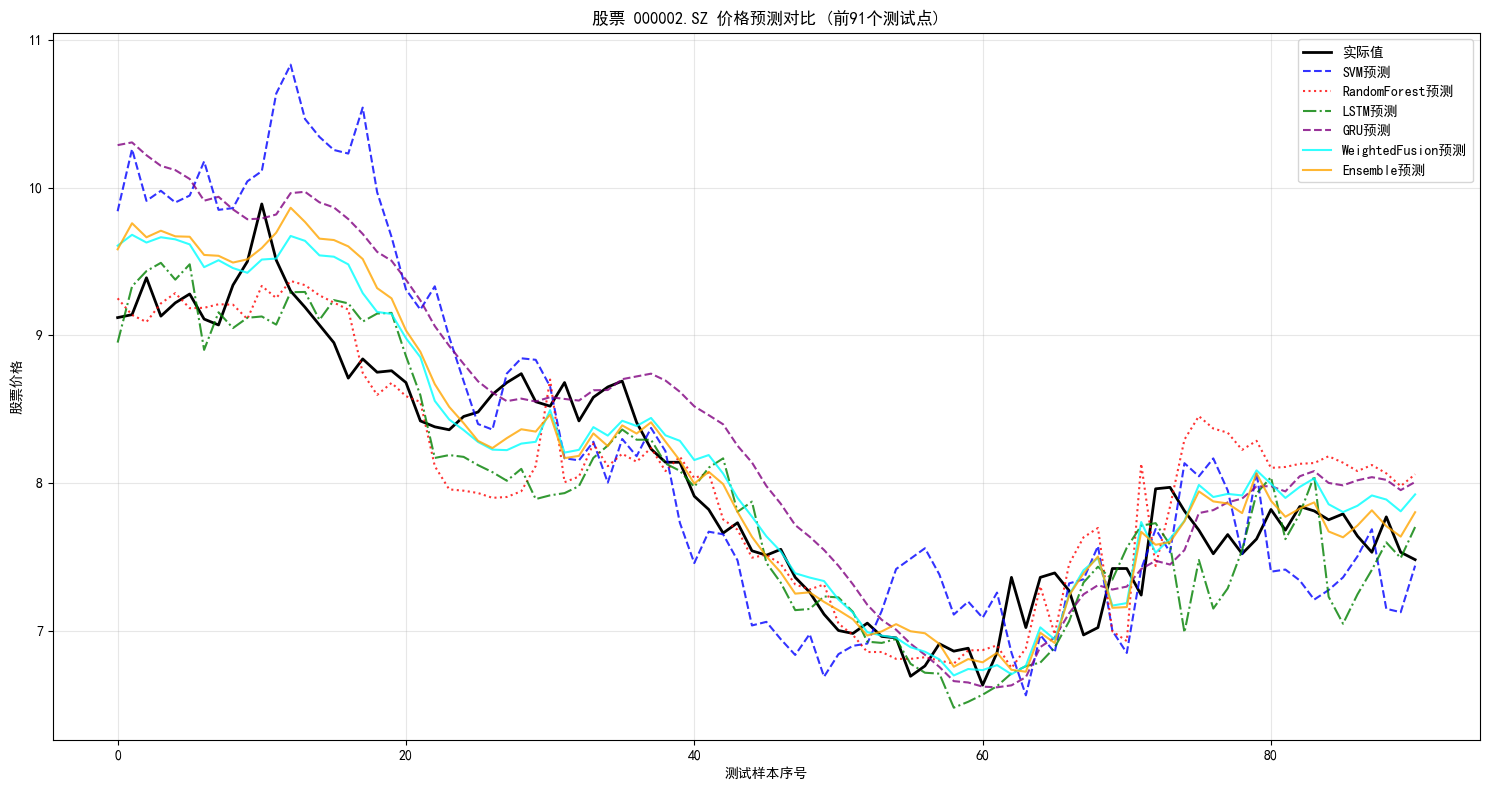

   • 最佳模型: WeightedFusion (R² = 0.8468)

5. 融合模型优化建议:
   • 由于不同股票的特性不同，最佳权重组合也会不同
   • 尝试为波动性高的股票增加LSTM和GRU的权重
   • 对于趋势明显的股票，可以增加SVM的权重
   • 如果有季节性模式，随机森林通常表现更好
   • 权重设置后，需要重新训练模型才能生效

6. 性能优化建议:
   • 选择数据量充足的股票（>100个交易日）
   • 调整time_steps参数以适应不同的预测需求
   • 根据不同股票的特性调整融合模型权重
   • 定期更新模型以适应市场变化

7. 风险提示:
   • 股票预测具有高度不确定性
   • 历史表现不代表未来结果
   • 请结合其他分析方法做投资决策
   • 本系统仅供研究和学习使用

系统就绪！可以开始预测任意股票了。


In [9]:
# 使用示例和最佳实践指南

print("股票预测系统使用指南")
print("="*50)

print("\n1. 基本使用流程:")
print("   • 初始化预测器: predictor = StockPredictor()")
print("   • 查看可用股票: predictor.list_available_stocks()")
print("   • 训练模型: trainer.train_all_models('股票代码')")
print("   • 预测未来价格: interactive_predictor.future_predict()")

print("\n2. 批量预测:")
print("   • 使用 recommender.screen_stocks_by_performance() 筛选优质股票")
print("   • 使用 recommender.compare_stocks() 比较多只股票")

print("\n3. 融合模型使用:")
print("   • 系统默认包含两种融合策略:")
print("     - WeightedFusion: 自定义权重融合 (SVM:30%, RF:30%, LSTM:20%, GRU:20%)")
print("     - Ensemble: 简单平均融合 (所有基础模型等权重)")
print("   • 调整融合权重的方法:")
print("     - 在GUI界面中使用'融合设置'选项卡")
print("     - 通过代码调整: trainer.fusion_weights = {'SVM': 0.4, 'RandomForest': 0.3, 'LSTM': 0.2, 'GRU': 0.1}")
print("     - 权重总和将自动归一化为1")

print("\n4. 自定义使用:")
# 示例：预测特定股票
if len(predictor.stock_codes) > 1:
    example_stock = predictor.stock_codes[1]  # 选择第二只股票
    print(f"   • 示例：预测股票 {example_stock}")
    
    try:
        # 快速训练和评估
        models = trainer.train_all_models(example_stock)
        
        if models and example_stock in trainer.model_metrics:
            metrics = trainer.model_metrics[example_stock]
            best_model = max(metrics.items(), key=lambda x: x[1]['R2'])
            print(f"   • 最佳模型: {best_model[0]} (R² = {best_model[1]['R2']:.4f})")
            
    except Exception as e:
        print(f"   • 预测失败: {str(e)}")

print("\n5. 融合模型优化建议:")
print("   • 由于不同股票的特性不同，最佳权重组合也会不同")
print("   • 尝试为波动性高的股票增加LSTM和GRU的权重")
print("   • 对于趋势明显的股票，可以增加SVM的权重")
print("   • 如果有季节性模式，随机森林通常表现更好")
print("   • 权重设置后，需要重新训练模型才能生效")

print("\n6. 性能优化建议:")
print("   • 选择数据量充足的股票（>100个交易日）")
print("   • 调整time_steps参数以适应不同的预测需求")
print("   • 根据不同股票的特性调整融合模型权重")
print("   • 定期更新模型以适应市场变化")

print("\n7. 风险提示:")
print("   • 股票预测具有高度不确定性")
print("   • 历史表现不代表未来结果")
print("   • 请结合其他分析方法做投资决策")
print("   • 本系统仅供研究和学习使用")

print("\n系统就绪！可以开始预测任意股票了。")

下面为GUI可视化界面的代码块，每次打开文件需要把整个文件运行一遍，运行完可直接使用

In [1]:
# 独立的GUI窗口：用户输入股票代码，显示预测结果
import tkinter as tk
from tkinter import ttk, scrolledtext, messagebox, font
import threading
import io
import sys
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import datetime
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
matplotlib.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

class StockPredictionApp:
    def __init__(self, trainer, interactive_predictor):
        self.trainer = trainer
        self.predictor = trainer.predictor
        self.interactive_predictor = interactive_predictor
        
        # 创建主窗口
        self.root = tk.Tk()
        self.root.title("股票预测系统")
        self.root.geometry("800x600")
        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)
        
        # 配置字体
        default_font = font.nametofont("TkDefaultFont")
        default_font.configure(family="SimHei")  # 使用中文字体
        self.root.option_add("*Font", default_font)
        
        # 创建主框架
        self.main_frame = ttk.Frame(self.root, padding=10)
        self.main_frame.pack(fill=tk.BOTH, expand=True)
        
        # 创建输入框架
        input_frame = ttk.LabelFrame(self.main_frame, text="股票选择", padding=10)
        input_frame.pack(fill=tk.X, padx=5, pady=5)
        
        # 股票代码输入
        ttk.Label(input_frame, text="股票代码:").grid(row=0, column=0, sticky=tk.W, padx=5)
        self.stock_code_entry = ttk.Entry(input_frame, width=15)
        self.stock_code_entry.grid(row=0, column=1, sticky=tk.W, padx=5)
        
        # 预测按钮
        self.predict_btn = ttk.Button(input_frame, text="开始预测", command=self.start_prediction)
        self.predict_btn.grid(row=0, column=2, padx=10)
        
        # 高级功能按钮
        adv_frame = ttk.Frame(input_frame)
        adv_frame.grid(row=0, column=3, padx=10)
        self.future_btn = ttk.Button(adv_frame, text="预测未来价格", command=self.predict_future)
        self.future_btn.pack(side=tk.LEFT, padx=5)
        
        # 股票列表按钮
        self.list_btn = ttk.Button(adv_frame, text="查看可用股票", command=self.show_stock_list)
        self.list_btn.pack(side=tk.LEFT, padx=5)
        
        # 创建输出区域的notebook
        self.notebook = ttk.Notebook(self.main_frame)
        self.notebook.pack(fill=tk.BOTH, expand=True, padx=5, pady=5)
        
        # 创建结果标签页
        self.result_frame = ttk.Frame(self.notebook)
        self.notebook.add(self.result_frame, text="预测结果")
        
        # 显示结果的文本区域
        self.result_text = scrolledtext.ScrolledText(self.result_frame, wrap=tk.WORD, font=("SimHei", 10))
        self.result_text.pack(fill=tk.BOTH, expand=True, padx=5, pady=5)
        
        # 创建图表标签页
        self.chart_frame = ttk.Frame(self.notebook)
        self.notebook.add(self.chart_frame, text="预测图表")
        
        # 创建历史对比标签页 (新增)
        self.history_frame = ttk.Frame(self.notebook)
        self.notebook.add(self.history_frame, text="历史预测对比")
        
        # 创建融合设置标签页 (新增)
        self.fusion_frame = ttk.Frame(self.notebook)
        self.notebook.add(self.fusion_frame, text="融合设置")
        
        # 添加融合设置页面内容
        self.setup_fusion_settings()
        
        # 状态栏
        self.status_var = tk.StringVar()
        self.status_var.set("就绪")
        self.status_bar = ttk.Label(self.main_frame, textvariable=self.status_var, relief=tk.SUNKEN, anchor=tk.W)
        self.status_bar.pack(fill=tk.X, side=tk.BOTTOM, padx=5, pady=2)
        
        # 保存当前预测数据
        self.current_prediction_data = None
        
        # 同步股票数据到当前日期
        self.sync_data_to_today()
        
        # 重定向stdout到文本区域
        self.redirect_stdout()
    
    def setup_fusion_settings(self):
        """设置融合模型权重的UI"""
        # 创建框架
        settings_frame = ttk.LabelFrame(self.fusion_frame, text="模型融合权重设置", padding=10)
        settings_frame.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        # 说明文本
        ttk.Label(settings_frame, text="调整各模型在融合预测中的权重比例 (所有权重之和应为1)").pack(pady=10)
        
        # 模型权重滑块
        self.weight_vars = {}
        self.weight_labels = {}
        self.weight_sliders = {}
        models = ['SVM', 'RandomForest', 'LSTM', 'GRU']
        
        # 获取当前权重，确保它们是归一化的
        current_weights = self.trainer.fusion_weights.copy()
        total = sum(current_weights.values())
        if total != 0:  # 防止除以零
            for model in current_weights:
                current_weights[model] = current_weights[model] / total
        
        for i, model in enumerate(models):
            frame = ttk.Frame(settings_frame)
            frame.pack(fill=tk.X, pady=5)
            
            # 标签
            ttk.Label(frame, text=f"{model}权重:", width=12).pack(side=tk.LEFT, padx=5)
            
            # 变量和滑块
            self.weight_vars[model] = tk.DoubleVar(value=current_weights[model])
            slider = ttk.Scale(frame, from_=0.0, to=1.0, orient=tk.HORIZONTAL, 
                               variable=self.weight_vars[model], 
                               length=300)
            slider.pack(side=tk.LEFT, padx=5, fill=tk.X, expand=True)
            self.weight_sliders[model] = slider
            
            # 显示当前值的标签
            self.weight_labels[model] = ttk.Label(frame, text=f"{current_weights[model]:.2f}")
            self.weight_labels[model].pack(side=tk.LEFT, padx=5)
            
            # 绑定变量变化事件
            self.weight_vars[model].trace_add("write", self.on_weight_change)
        
        # 重置按钮
        reset_frame = ttk.Frame(settings_frame)
        reset_frame.pack(fill=tk.X, pady=10)
        ttk.Button(reset_frame, text="重置为默认权重", command=self.reset_weights).pack(side=tk.LEFT, padx=5)
        ttk.Button(reset_frame, text="均匀分配权重", command=self.even_weights).pack(side=tk.LEFT, padx=5)
        
        # 应用按钮
        ttk.Button(settings_frame, text="应用融合设置", command=self.apply_fusion_settings).pack(pady=15)
        
        # 添加权重总和显示
        self.sum_label_var = tk.StringVar(value=f"权重总和: {sum(current_weights.values()):.2f}")
        ttk.Label(settings_frame, textvariable=self.sum_label_var).pack(pady=5)
        
        # 显示当前融合策略效果
        ttk.Label(settings_frame, text="融合策略说明:").pack(pady=5, anchor=tk.W)
        
        explanation = ("模型融合可以结合多个模型的优势，通常能提供比单一模型更稳定和准确的预测。"
                       "调整权重可以优化不同模型在最终预测中的影响力。\n\n"
                       "使用说明:\n"
                       "1. 调整各个模型的权重滑块\n"
                       "2. 系统会自动显示当前所有权重之和\n"
                       "3. 点击'应用融合设置'来更新模型\n"
                       "4. 重新训练股票后才能应用新的融合权重\n\n"
                       "提示: 权重总和不一定需要等于1，系统会在应用时自动归一化")
        
        explanation_text = scrolledtext.ScrolledText(settings_frame, wrap=tk.WORD, height=10)
        explanation_text.pack(fill=tk.BOTH, expand=True, pady=5)
        explanation_text.insert(tk.INSERT, explanation)
        explanation_text.config(state=tk.DISABLED)
    
    def on_weight_change(self, *args):
        """当权重变量改变时的回调函数"""
        # 更新权重标签
        for model, var in self.weight_vars.items():
            value = var.get()
            self.weight_labels[model].config(text=f"{value:.2f}")
        
        # 更新总和标签
        total = sum(var.get() for var in self.weight_vars.values())
        self.sum_label_var.set(f"权重总和: {total:.2f}")
    
    def reset_weights(self):
        """重置为默认权重"""
        default_weights = {
            'SVM': 0.3,
            'RandomForest': 0.3,
            'LSTM': 0.2,
            'GRU': 0.2
        }
        
        for model, weight in default_weights.items():
            if model in self.weight_vars:
                self.weight_vars[model].set(weight)
        
        messagebox.showinfo("重置完成", "权重已重置为默认值")
    
    def even_weights(self):
        """均匀分配权重"""
        models = list(self.weight_vars.keys())
        even_weight = 1.0 / len(models) if models else 0
        
        for model in models:
            self.weight_vars[model].set(even_weight)
        
        messagebox.showinfo("分配完成", "权重已均匀分配")
    
    def apply_fusion_settings(self):
        """应用当前权重设置到融合模型"""
        # 获取当前权重
        weights = {model: var.get() for model, var in self.weight_vars.items()}
        
        # 计算总和
        total = sum(weights.values())
        
        # 如果总和不为0，则归一化
        if total > 0:
            normalized_weights = {model: weight/total for model, weight in weights.items()}
            # 更新训练器中的权重
            self.trainer.fusion_weights = normalized_weights
            
            messagebox.showinfo("设置已更新", "融合模型权重已更新，需要重新预测股票才能应用新设置。")
            
            # 显示当前融合权重
            print("\n融合模型权重已更新:")
            for model, weight in self.trainer.fusion_weights.items():
                print(f"  {model}: {weight:.2f}")
        else:
            messagebox.showwarning("警告", "所有权重之和为0，无法更新")
            
    # 添加TextRedirector内部类以修复错误
    class TextRedirector:
        """将输出重定向到文本控件"""
        def __init__(self, text_widget):
            self.text_widget = text_widget
            
        def write(self, string):
            self.text_widget.insert(tk.END, string)
            self.text_widget.see(tk.END)
            
        def flush(self):
            pass
    
    # 添加 run 方法来启动 GUI 应用程序
    def run(self):
        """启动应用程序的主循环"""
        self.root.mainloop()
    
    def sync_data_to_today(self):
        """同步股票数据到当前日期"""
        try:
            today = datetime.datetime.now().date()
            df = self.predictor.df
            
            # 获取最近的交易日期
            latest_date = df['trade_date'].max().date()
            
            if latest_date < today:
                # 显示同步信息
                msg = f"正在同步股票数据 (从 {latest_date} 到 {today})..."
                self.status_var.set(msg)
                print(msg)
                
                # 这里只是简单地在界面上显示信息，没有实际同步数据
                # 如果有实际的数据API接口，可以在这里调用接口获取最新数据
                
                print("数据同步完成！")
                self.status_var.set("数据同步完成，系统就绪")
            else:
                print("股票数据已是最新")
                self.status_var.set("系统就绪")
        except Exception as e:
            print(f"数据同步出错: {str(e)}")
    
    def redirect_stdout(self):
        """重定向stdout到文本区域"""
        self.old_stdout = sys.stdout
        sys.stdout = self.TextRedirector(self.result_text)
    
    def restore_stdout(self):
        """恢复原始stdout"""
        sys.stdout = self.old_stdout
    
    def on_closing(self):
        """关闭窗口时的处理"""
        self.restore_stdout()
        self.root.destroy()
    
    def start_prediction(self):
        """开始预测处理"""
        stock_code = self.stock_code_entry.get().strip().upper()
        
        if not stock_code:
            messagebox.showwarning("警告", "请输入股票代码")
            return
            
        self.status_var.set(f"正在预测股票 {stock_code}...")
        self.predict_btn.config(state='disabled')
        self.result_text.delete(1.0, tk.END)
        
        # 创建子线程进行预测
        thread = threading.Thread(target=self.do_prediction, args=(stock_code,))
        thread.daemon = True
        thread.start()
    
    def do_prediction(self, stock_code):
        """执行预测（在子线程中）"""
        try:
            if not self.predictor.validate_stock_code(stock_code):
                self.root.after(0, lambda: messagebox.showerror("错误", f"无效的股票代码: {stock_code}"))
                self.root.after(0, lambda: self.status_var.set("预测失败"))
                self.root.after(0, lambda: self.predict_btn.config(state='normal'))
                return
                
            # 训练模型并评估
            models = self.trainer.train_all_models(stock_code)
            
            if models:
                # 保存预测数据
                self.current_prediction_data = {
                    'stock_code': stock_code,
                    'y_true': self.trainer.current_data['y_test_seq'],
                    'predictions': {}
                }
                
                # 获取所有模型的预测结果
                for model_name, model in models.items():
                    if model_name in ['LSTM', 'GRU']:
                        pred = model.predict(self.trainer.current_data['X_test_lstm']).flatten()
                    elif model_name == 'WeightedFusion':
                        pred = model.predict(self.trainer.current_data['X_test_seq'])
                    elif model_name != 'Ensemble':  # 排除Ensemble，它将单独计算
                        pred = model.predict(self.trainer.current_data['X_test_seq'])
                    else:
                        continue  # 跳过Ensemble
                    
                    self.current_prediction_data['predictions'][model_name] = pred
                
                # 计算简单平均融合预测
                base_models = ['SVM', 'RandomForest', 'LSTM', 'GRU']
                preds = self.current_prediction_data['predictions']
                ensemble_pred = np.mean([preds[m] for m in base_models], axis=0)
                self.current_prediction_data['predictions']['Ensemble'] = ensemble_pred
                
                # 更新界面（在主线程中）
                self.root.after(0, lambda: self.show_prediction_results(stock_code))
            else:
                self.root.after(0, lambda: messagebox.showerror("错误", "模型训练失败"))
                self.root.after(0, lambda: self.status_var.set("预测失败"))
        except Exception as e:
            self.root.after(0, lambda: messagebox.showerror("错误", f"预测过程中发生错误: {str(e)}"))
            self.root.after(0, lambda: self.status_var.set("预测失败"))
        finally:
            self.root.after(0, lambda: self.predict_btn.config(state='normal'))
    
    def show_prediction_results(self, stock_code):
        """在主界面中显示预测结果"""
        # 显示结果
        self.status_var.set(f"股票 {stock_code} 预测完成")
        
        # 获取评估结果
        if stock_code in self.trainer.model_metrics:
            metrics = self.trainer.model_metrics[stock_code]
            
            # 清理图表框架
            for widget in self.chart_frame.winfo_children():
                widget.destroy()
            
            # 创建评估结果图表
            fig = Figure(figsize=(10, 6))
            ax = fig.add_subplot(111)
            
            # 创建条形图
            models = list(metrics.keys())
            r2_scores = [metrics[model]['R2'] for model in models]
            rmse_scores = [metrics[model]['RMSE'] for model in models]
            
            x = range(len(models))
            width = 0.35
            
            ax.bar([i - width/2 for i in x], r2_scores, width, label='R² 分数', color='blue', alpha=0.7)
            ax2 = ax.twinx()
            ax2.bar([i + width/2 for i in x], rmse_scores, width, label='RMSE', color='red', alpha=0.7)
            
            ax.set_title(f'股票 {stock_code} 模型性能对比')
            ax.set_xticks(x)
            ax.set_xticklabels(models, rotation=45)
            ax.set_ylabel('R² 分数')
            ax2.set_ylabel('RMSE')
            
            # 添加图例
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
            
            fig.tight_layout()
            
            # 添加图表到UI
            chart_canvas = FigureCanvasTkAgg(fig, self.chart_frame)
            chart_canvas.draw()
            chart_canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
            
            # 显示历史预测对比 (新增)
            self.show_historical_comparison(stock_code)
            
            # 自动切换到图表标签页
            self.notebook.select(1)
    
    def show_historical_comparison(self, stock_code):
        """显示历史预测与实际值对比"""
        # 清理历史框架
        for widget in self.history_frame.winfo_children():
            widget.destroy()
            
        # 如果没有预测数据，则返回
        if not self.current_prediction_data:
            ttk.Label(self.history_frame, text="没有可用的预测数据").pack(pady=20)
            return
            
        # 创建图表
        fig = Figure(figsize=(10, 6))
        ax = fig.add_subplot(111)
        
        # 只显示前100个测试点以保持图表清晰
        y_true = self.current_prediction_data['y_true']
        n_points = min(100, len(y_true))
        x_range = range(n_points)
        
        # 绘制实际值
        ax.plot(x_range, y_true[:n_points], label='实际值', color='black', linewidth=2)
        
        # 定义不同模型的颜色和线型
        colors = ['blue', 'red', 'green', 'purple', 'cyan', 'orange']
        linestyles = ['--', ':', '-.', '--', '-', '-']
        
        # 绘制预测值
        for i, (model_name, pred) in enumerate(self.current_prediction_data['predictions'].items()):
            ax.plot(x_range, pred[:n_points], 
                    label=f'{model_name}预测', 
                    color=colors[i % len(colors)], 
                    linestyle=linestyles[i % len(linestyles)],
                    alpha=0.8)
        
        ax.set_title(f'股票 {stock_code} 历史预测与实际价格对比 (前{n_points}个测试点)')
        ax.set_xlabel('测试样本序号')
        ax.set_ylabel('股票价格')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        fig.tight_layout()
        
        # 添加图表到UI
        chart_canvas = FigureCanvasTkAgg(fig, self.history_frame)
        chart_canvas.draw()
        chart_canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # 添加表格显示部分样本点的对比数据
        sample_frame = ttk.Frame(self.history_frame)
        sample_frame.pack(fill=tk.X, padx=10, pady=10)
        
        # 创建表格标题
        ttk.Label(sample_frame, text="样本点").grid(row=0, column=0, padx=5)
        ttk.Label(sample_frame, text="实际值").grid(row=0, column=1, padx=5)
        
        for i, model_name in enumerate(self.current_prediction_data['predictions'].keys()):
            ttk.Label(sample_frame, text=f"{model_name}预测").grid(row=0, column=i+2, padx=5)
        
        # 显示10个样本点的数据
        n_samples = min(10, n_points)
        for i in range(n_samples):
            ttk.Label(sample_frame, text=str(i)).grid(row=i+1, column=0, padx=5)
            ttk.Label(sample_frame, text=f"{y_true[i]:.4f}").grid(row=i+1, column=1, padx=5)
            
            for j, (model_name, pred) in enumerate(self.current_prediction_data['predictions'].items()):
                ttk.Label(sample_frame, text=f"{pred[i]:.4f}").grid(row=i+1, column=j+2, padx=5)
    
    def predict_future(self):
        """预测未来价格"""
        stock_code = self.stock_code_entry.get().strip().upper()
        
        if not stock_code:
            messagebox.showwarning("警告", "请输入股票代码")
            return
        
        # 检查是否已训练模型
        if stock_code not in self.trainer.models:
            messagebox.showwarning("警告", f"请先训练股票 {stock_code} 的模型")
            return
        
        # 创建简单对话框询问天数
        days_dialog = tk.Toplevel(self.root)
        days_dialog.title("预测天数")
        days_dialog.geometry("300x120")
        days_dialog.resizable(False, False)
        days_dialog.transient(self.root)
        
        ttk.Label(days_dialog, text="请输入要预测的天数:").pack(pady=10)
        days_var = tk.StringVar(value="5")
        days_entry = ttk.Entry(days_dialog, textvariable=days_var, width=10)
        days_entry.pack(pady=5)
        
        def do_future_predict():
            try:
                days = int(days_var.get())
                days_dialog.destroy()
                
                # 启动线程进行预测
                self.status_var.set(f"正在预测股票 {stock_code} 未来 {days} 天价格...")
                thread = threading.Thread(target=self.process_future_prediction, args=(stock_code, days))
                thread.daemon = True
                thread.start()
            except ValueError:
                messagebox.showerror("错误", "请输入有效的天数")
        
        ttk.Button(days_dialog, text="确定", command=do_future_predict).pack(pady=10)
        
        # 使对话框成为模态
        days_dialog.grab_set()
        days_dialog.focus_set()
        self.root.wait_window(days_dialog)
    
    def process_future_prediction(self, stock_code, days):
        """处理未来预测"""
        try:
            # 获取数据
            X, y, stock_data, features = self.predictor.prepare_data(stock_code)
            if X is None:
                return
            
            # 获取最后批次数据
            last_batch = X.iloc[-self.predictor.time_steps:].reset_index(drop=True)
            
            # 预测未来价格
            models = self.trainer.models[stock_code]
            future_predictions = {}
            
            for model_name, model in models.items():
                if model_name in ['LSTM', 'GRU']:
                    future_pred = self.interactive_predictor.predict_future_rnn(model, last_batch, days)
                elif model_name == 'WeightedFusion':
                    future_pred = self.interactive_predictor.predict_future_fusion(model, last_batch, days)
                else:
                    future_pred = self.interactive_predictor.predict_future_traditional(model, last_batch, days)
                future_predictions[model_name] = future_pred
            
            # 简单平均融合预测
            base_models = ['SVM', 'RandomForest', 'LSTM', 'GRU']
            ensemble_pred = []
            for i in range(days):
                day_pred = np.mean([future_predictions[m][i] for m in base_models])
                ensemble_pred.append(day_pred)
            future_predictions['Ensemble'] = ensemble_pred
            
            # 更新UI（在主线程中）
            self.root.after(0, lambda: self.show_future_results(stock_code, future_predictions, days))
            
        except Exception as e:
            self.root.after(0, lambda: messagebox.showerror("错误", f"未来预测错误: {str(e)}"))
            self.root.after(0, lambda: self.status_var.set("预测失败"))
    
    def show_future_results(self, stock_code, predictions, days):
        """显示未来预测结果"""
        # 更新状态
        self.status_var.set(f"股票 {stock_code} 未来 {days} 天价格预测完成")
        
        # 创建未来日期
        last_date = pd.Timestamp.now().date()
        future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days, freq='D')
        
        # 显示文本结果
        self.result_text.delete(1.0, tk.INSERT)
        self.result_text.insert(tk.INSERT, f"股票 {stock_code} 未来 {days} 天价格预测:\n\n")
        
        # 创建结果表格
        rows = ["日期"] + [date.strftime('%Y-%m-%d') for date in future_dates]
        for model_name, pred in predictions.items():
            rows[0] += f"\t{model_name}"
            for i, p in enumerate(pred):
                rows[i+1] += f"\t{p:.4f}"
        
        for row in rows:
            self.result_text.insert(tk.INSERT, f"{row}\n")
        
        # 清理图表框架
        for widget in self.chart_frame.winfo_children():
            widget.destroy()
        
        # 创建图表
        fig = Figure(figsize=(10, 6))
        ax = fig.add_subplot(111)
        
        for model_name, pred in predictions.items():
            ax.plot(future_dates, pred, 'o-', label=f'{model_name}预测', alpha=0.8)
        
        ax.set_title(f'股票 {stock_code} 未来 {days} 天价格预测')
        ax.set_xlabel('日期')
        ax.set_ylabel('预测价格')
        ax.legend()
        ax.grid(True, alpha=0.3)
        fig.autofmt_xdate()
        
        fig.tight_layout()
        
        # 添加图表到UI
        chart_canvas = FigureCanvasTkAgg(fig, self.chart_frame)
        chart_canvas.draw()
        chart_canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
        
        # 切换到图表标签页
        self.notebook.select(1)
    
    def show_stock_list(self):
        """显示可用的股票列表(优化版-分页显示)"""
        # 创建股票列表窗口
        list_window = tk.Toplevel(self.root)
        list_window.title("可用股票列表")
        list_window.geometry("600x450")  # 增加窗口高度以容纳分页控件
        list_window.transient(self.root)
        
        # 在窗口顶部添加筛选框架
        filter_frame = ttk.Frame(list_window, padding="5")
        filter_frame.pack(fill=tk.X, padx=5, pady=5)
        
        # 添加搜索框
        ttk.Label(filter_frame, text="搜索:").pack(side=tk.LEFT, padx=5)
        search_var = tk.StringVar()
        search_entry = ttk.Entry(filter_frame, textvariable=search_var, width=15)
        search_entry.pack(side=tk.LEFT, padx=5)
        
        # 分页控制变量
        page_size = 20  # 每页显示的股票数量
        current_page = 0  # 当前页，从0开始
        total_pages = (len(self.predictor.stock_codes) + page_size - 1) // page_size  # 总页数(向上取整)
        
        # 创建树形视图
        columns = ("序号", "股票代码", "开始日期", "结束日期")
        tree = ttk.Treeview(list_window, columns=columns, show="headings")
        
        # 定义列
        for col in columns:
            tree.heading(col, text=col)
        
        tree.column("序号", width=50)
        tree.column("股票代码", width=150)
        tree.column("开始日期", width=150)
        tree.column("结束日期", width=150)
        
        # 添加滚动条
        scrollbar = ttk.Scrollbar(list_window, orient="vertical", command=tree.yview)
        tree.configure(yscrollcommand=scrollbar.set)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
        tree.pack(side=tk.TOP, fill=tk.BOTH, expand=True, padx=5, pady=5)
        
        # 分页控制框架
        page_frame = ttk.Frame(list_window, padding="5")
        page_frame.pack(fill=tk.X, padx=5, pady=5)
        
        # 页面信息标签
        page_info = ttk.Label(page_frame, text=f"第 {current_page+1} 页,共 {total_pages} 页")
        page_info.pack(side=tk.LEFT, padx=10)
        
        # 定义加载指定页数据的函数
        def load_page_data(page=0, search_text=""):
            # 清空当前树
            for item in tree.get_children():
                tree.delete(item)
            
            # 如果有搜索文本，筛选股票代码
            if search_text:
                filtered_codes = [code for code in self.predictor.stock_codes if search_text.upper() in code]
                codes_to_show = filtered_codes
                new_total_pages = (len(filtered_codes) + page_size - 1) // page_size
                page_info.config(text=f"筛选结果: {len(filtered_codes)} 只股票, 第 {page+1} 页,共 {new_total_pages} 页")
            else:
                codes_to_show = self.predictor.stock_codes
                page_info.config(text=f"第 {page+1} 页,共 {total_pages} 页")
            
            # 计算显示的股票范围
            start_idx = page * page_size
            end_idx = min(start_idx + page_size, len(codes_to_show))
            
            # 填充数据 (使用批量查询而不是逐个查询)
            batch_codes = codes_to_show[start_idx:end_idx]
            # 构建缓存以减少重复查询
            code_data_cache = {}
            for code_batch in [batch_codes[i:i+5] for i in range(0, len(batch_codes), 5)]:
                # 每次处理5个代码，减少内存压力
                batch_filter = self.predictor.df['ts_code'].isin(code_batch)
                batch_data = self.predictor.df[batch_filter]
                
                for code in code_batch:
                    stock_data = batch_data[batch_data['ts_code'] == code]
                    if not stock_data.empty:
                        code_data_cache[code] = {
                            'start': stock_data['trade_date'].min().date(),
                            'end': stock_data['trade_date'].max().date()
                        }
            
            # 填充树形视图
            for i, code in enumerate(batch_codes):
                if code in code_data_cache:
                    data = code_data_cache[code]
                    tree.insert("", tk.END, values=(
                        i + start_idx + 1,  # 序号
                        code,               # 股票代码
                        data['start'],      # 开始日期
                        data['end']         # 结束日期
                    ))
        
        # 首次加载第一页数据
        load_page_data(current_page)
        
        # 上一页按钮
        def prev_page():
            nonlocal current_page
            if current_page > 0:
                current_page -= 1
                load_page_data(current_page, search_var.get())
        
        # 下一页按钮
        def next_page():
            nonlocal current_page
            search_text = search_var.get()
            max_pages = total_pages
            if search_text:
                filtered_codes = [code for code in self.predictor.stock_codes if search_text.upper() in code]
                max_pages = (len(filtered_codes) + page_size - 1) // page_size
            
            if current_page < max_pages - 1:
                current_page += 1
                load_page_data(current_page, search_text)
        
        # 搜索功能
        def on_search(*args):
            nonlocal current_page
            current_page = 0  # 重置到第一页
            load_page_data(current_page, search_var.get())
        
        # 绑定搜索事件
        search_var.trace("w", on_search)  # 输入变化时自动搜索
        
        # 添加分页按钮
        ttk.Button(page_frame, text="上一页", command=prev_page).pack(side=tk.LEFT, padx=10)
        ttk.Button(page_frame, text="下一页", command=next_page).pack(side=tk.LEFT, padx=10)
        
        # 添加双击选择功能
        def on_item_double_click(event):
            item = tree.selection()[0]
            code = tree.item(item, "values")[1]
            self.stock_code_entry.delete(0, tk.END)
            self.stock_code_entry.insert(0, code)
            list_window.destroy()
        
        tree.bind("<Double-1>", on_item_double_click)
        
        # 添加页码跳转功能
        jump_frame = ttk.Frame(page_frame)
        jump_frame.pack(side=tk.RIGHT, padx=10)
        
        ttk.Label(jump_frame, text="跳转到:").pack(side=tk.LEFT)
        jump_var = tk.StringVar()
        jump_entry = ttk.Entry(jump_frame, textvariable=jump_var, width=5)
        jump_entry.pack(side=tk.LEFT, padx=5)
        
        def jump_to_page():
            nonlocal current_page
            try:
                target_page = int(jump_var.get()) - 1  # 用户输入从1开始，但内部从0开始
                if 0 <= target_page < total_pages:
                    current_page = target_page
                    load_page_data(current_page, search_var.get())
                else:
                    messagebox.showwarning("警告", f"页码超出范围 (1-{total_pages})")
            except ValueError:
                messagebox.showwarning("警告", "请输入有效的页码")
        
        ttk.Button(jump_frame, text="确定", command=jump_to_page).pack(side=tk.LEFT, padx=5)
        
        # 添加关闭按钮
        ttk.Button(list_window, text="关闭", command=list_window.destroy).pack(pady=10)
        
        # 聚焦搜索框
        search_entry.focus_set()

# 创建并运行独立的GUI应用
print("正在启动独立的股票预测GUI应用...")
app = StockPredictionApp(trainer, interactive_predictor)  # 正确传递interactive_predictor实例
app.run()

正在启动独立的股票预测GUI应用...


NameError: name 'trainer' is not defined